In [1]:
# !sudo pip install -U nltk
# !sudo pip install wget
# !sudo pip install tflearn

In [1]:
import sys
print(sys.version)
import tensorflow as tf
print(tf.__version__)
import nltk

3.6.3 |Anaconda, Inc.| (default, Oct 13 2017, 12:02:49) 
[GCC 7.2.0]


/home/arunima/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


1.4.1


In [2]:
import pandas as pd
import gzip
import time
import tensorflow as tf
import tflearn
# Install a few python packages using pip
#from common import utils
from common import utils
utils.require_package('nltk')
utils.require_package("wget")      # for fetching dataset
#from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import accuracy_score, classification_report, f1_score, roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Standard python helper libraries.
from __future__ import print_function
from __future__ import division
import os, sys, time
import collections
import itertools

# Numerical manipulation libraries.
import numpy as np
from scipy import stats, optimize

import nltk
nltk.download('punkt')
from nltk import word_tokenize


#comment or uncomment based on anamika/ arunima
# Helper libraries
# from common import utils, vocabulary, glove_helper

# from common import utils, vocabulary
from common import utils, vocabulary
from common import glove_helper

[nltk_data] Downloading package punkt to /home/arunima/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
#Function to read the amazon review data files
def parse(path):
  print('start parse')
  start_parse = time.time()
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
  end_parse = time.time()
  print('end parse with time for parse',end_parse - start_parse)

def getDF(path):
  print('start getDF')
  start = time.time()
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  print('end getDF')
  end = time.time()
  print('time taken to load data = ',end-start)
  return pd.DataFrame.from_dict(df, orient='index')
#df = getDF('reviews_Toys_and_Games.json.gz') #old def function corresponding to the step bt step vectorization

In [5]:
#Using pretrained GLove embeddings
hands = glove_helper.Hands(ndim=100)  # 50, 100, 200, 300 dim are available
hands.shape
print(hands.shape[1])

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))
100


# Please note that i had to comment out the path. Please uncomment before running

In [6]:
#df_toys = getDF('/newvolume/reviews_Toys_and_Games.json.gz')
df_toys = getDF('reviews_Toys_and_Games.json.gz')

start getDF
start parse
end parse with time for parse 120.41323447227478
end getDF
time taken to load data =  120.41351127624512


In [8]:
#df_vid = getDF('/newvolume/reviews_Video_Games.json.gz')
df_vid = getDF('reviews_Video_Games.json.gz')

start getDF
start parse
end parse with time for parse 78.07821440696716
end getDF
time taken to load data =  78.07865905761719


In [7]:
#df_aut = getDF('/newvolume/reviews_Automotive.json.gz')
df_aut = getDF('reviews_Automotive.json.gz')

start getDF
start parse
end parse with time for parse 67.88917350769043
end getDF
time taken to load data =  67.8895890712738


In [9]:
df_hnk = getDF('reviews_Home_and_Kitchen.json.gz')
#df_hnk = getDF('/newvolume/reviews_Home_and_Kitchen.json.gz')

start getDF
start parse
end parse with time for parse 229.32517433166504
end getDF
time taken to load data =  229.3255169391632


In [12]:
#Looking at a few examples of review text
# print('Toys reviews examples\n')
# for i in range(1):
#     print(df_toys['reviewerID'].iloc[i])
#     print(df_toys['reviewText'].iloc[i])

# print('\n Video games reviews examples\n')
# for i in range(1):
#     print(df_vid['reviewerID'].iloc[i])
#     print(df_vid['reviewText'].iloc[i])
    
# print('\n Automobile reviews examples\n')
# for i in range(1):
#     print(df_aut['reviewerID'].iloc[i])
#     print(df_aut['reviewText'].iloc[i])
    
print('\n Home and Kitchen reviews examples\n')
for i in range(2):
    print(df_hnk['reviewerID'].iloc[i])
    print(df_hnk['reviewText'].iloc[i])


 Home and Kitchen reviews examples

A210NOCSTBT4OD
Have you ever thought about how you met your best friend? Was it normal, or was it wacky - like how Elias met Shohei? Pulling a boa constrictor snake named Mathilda out of your backpack can make a remarkable first impression! This book is about three best friends Elias, Honoria, and Shohei, who are united against "That Which Is The Peshtigo School". Their goal is to make it through the annual school science fair, but things don't always go as planned.Elias is part of a family made up of science fanatics who would do anything to win a science fair. Elias isn't exactly what you'd call the ambitious type, especially when it comes to science fairs. So he becomes like Galileo and "retests" one of his sibling's past projects. Honoria loves to be ambitious, especially when it comes to being a legal counsel extraordinaire. But when she faces a bigger challenge than beating Goliath Reed or getting a piranha to become vegetarian, she doesn't kn

In [10]:
# Create train,dev,test split
from sklearn.model_selection import train_test_split
train_toys,devtest = train_test_split(df_toys, test_size=0.4, random_state=42)
dev_toys,test_toys = train_test_split(devtest,test_size = 0.5, random_state=42)
print('Toy reviews train, dev and test set dataframe shape:',train_toys.shape,dev_toys.shape,test_toys.shape)

#For Video games reviews
train_vid,devtest = train_test_split(df_vid, test_size=0.4, random_state=42)
dev_vid,test_vid = train_test_split(devtest,test_size = 0.5, random_state=42)
print('Video games reviews train, dev and test set dataframe shape:',train_vid.shape,dev_vid.shape,test_vid.shape)

#For Auto reviews
train_aut,devtest = train_test_split(df_aut, test_size=0.4, random_state=42)
dev_aut,test_aut = train_test_split(devtest,test_size = 0.5, random_state=42)
print('Auto reviews train, dev and test set dataframe shape:',train_aut.shape,dev_aut.shape,test_aut.shape)

#For Home and Kitchen reviews
train_hnk,devtest = train_test_split(df_hnk, test_size=0.4, random_state=42)
dev_hnk,test_hnk = train_test_split(devtest,test_size = 0.5, random_state=42)
print('Home and Kitchen reviews train, dev and test set dataframe shape:',train_hnk.shape,dev_hnk.shape,test_hnk.shape)

Toy reviews train, dev and test set dataframe shape: (1351662, 9) (450554, 9) (450555, 9)
Video games reviews train, dev and test set dataframe shape: (794851, 9) (264951, 9) (264951, 9)
Auto reviews train, dev and test set dataframe shape: (824260, 9) (274754, 9) (274754, 9)
Home and Kitchen reviews train, dev and test set dataframe shape: (2552355, 9) (850785, 9) (850786, 9)


In [11]:
#Function to create a smaller sized train and dev data set. Enables testing accuracy for different sizes.
#Also binarizes the labels. Ratings of 1,2 and to 0; Ratings of 4,5 to 1.

def set_df_size(size,data_train,data_dev):
    size_train = size
    len_max_train = data_train[data_train.overall!=3].shape[0] #max possible length of train data set taking out the 3 ratings.
    #print("Number of reviews with ratings != 3 in train set",len_max_train)
    temp_size_train = min(len_max_train,size_train)

    len_max_dev = data_dev[data_dev.overall!=3].shape[0]
    #print("Number of reviews with ratings != 3 in dev set",len_max_dev)
    temp_size_dev = min(len_max_dev,int(0.3*temp_size_train)) #making the dev set about 0.3 times the train set.

    temp_train_data = data_train[data_train.overall != 3][:temp_size_train]
    #print('Size of train data',temp_train_data.shape)
    #print(temp_train_data.groupby('overall').count())
    #print(temp_train_toys[:5])

    temp_dev_data = data_dev[data_dev.overall!=3][:temp_size_dev]
    #print('Size of dev data',temp_dev_data.shape)
    #print(temp_dev_data.groupby('overall').count())
    #print(temp_dev_data[:2])
    
    #Binarize ratings
    temp_train_y = np.zeros(temp_size_train)
    temp_train_y[temp_train_data.overall > 3] = 1
    temp_dev_y = np.zeros(temp_size_dev)
    temp_dev_y[temp_dev_data.overall>3] = 1
    #print('binarized y shape',temp_train_y.shape,temp_dev_y.shape)
    #print(temp_dev_y[:20],data_dev.overall[:20])
    return temp_train_data,temp_dev_data,temp_train_y,temp_dev_y

In [12]:
list_df = ['toys','vid','aut','hnk'] #list of keys that refer to each dataframe. Adding a new dataframe would require updating this list
dict_train_df = {} #Dict to store train input data frame for each domain, can be accessed by using domain name as key
dict_dev_df = {} #Dict to store dev input data frame for each domain, can be accessed by using domain name as key
dict_train_y = {} #Dict to store binarized train data label for each domain
dict_dev_y = {} #Dict to store binarized dev data label for each domain
#print(len(dict_train_df))

size_initial = 10000
def create_sized_data(size = 10000):
    size_train = size #Set size of train set here. This is a hyperparameter.
    key = list_df[0]
    #print('Toys reviews\n')
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_toys,dev_toys)
    #print('\n Video games reviews\n')
    key = list_df[1]
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_vid,dev_vid)
    #print('\n Auto reviews\n')
    key = list_df[2]
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_aut,dev_aut)
    #print('\n Home and Kitchen reviews\n')
    key = list_df[3]
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_hnk,dev_hnk)
    
create_sized_data(size_initial)
#create_sized_data(500)
#print(len(dict_train_df))

In [13]:
# vocab_processor = tflearn.data_utils.VocabularyProcessor(max_length, min_frequency=0)
#Note : Above function was used instead of the below, which is deprecated. 
# vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(max_length)

def process_inputs(key, vocab_processor):
    
    start_vectorize = time.time()
    x_train = dict_train_df[key].reviewText
    y_train = dict_train_y[key]
    x_dev = dict_dev_df[key].reviewText
    y_dev = dict_dev_y[key]
    print(x_train.shape)
    
    # Train the vocab_processor from the training set
    x_train = vocab_processor.fit_transform(x_train)
    # Transform our test set with the vocabulary processor
    x_dev = vocab_processor.transform(x_dev)

    # We need these to be np.arrays instead of generators
    x_train = np.array(list(x_train))
    print(x_train.shape)
    x_dev = np.array(list(x_dev))
    y_train = np.array(y_train).astype(int)
    y_dev = np.array(y_dev).astype(int)
    
#     y_train = tf.expand_dims(y_train,1)
#     y_dev = tf.expand_dims(y_dev,1)
    print('y train shape',y_train.shape)

    V = len(vocab_processor.vocabulary_)
    print('Total words: %d' % V)
    end_vectorize = time.time()
    print('Time taken to vectorize %d size dataframe'%x_train.shape[0],end_vectorize-start_vectorize)

    # Return the transformed data and the number of words
    return x_train, y_train, x_dev, y_dev, V

In [15]:
#Converting reviews to ids for all domains and add padding.

# Hyperparameters
min_frequency = 1
max_length = 150

dict_vectorizers = {} #Dict to store the vocab_processor fit on each domain
dict_train_ids = {} #Dict to store train data reviews as sparse matrix of word ids
dict_dev_ids = {} #Dict to store dev data reviews as sparse matrix of word ids
dict_cnn = {} #Dict to store cnn model developed on each domain. Assumes input features are developed using the corresponding count_vectorizer
dict_dev_ypred = {} #Dict to store dev predictions
dict_vocab_len = {} #Store vocab length of each domain
for key in list_df:
    
    #Converting ratings to tokenized word id counts as a sparse matrix using count_vectorizer
    dict_vectorizers[key] = tflearn.data_utils.VocabularyProcessor(max_length, min_frequency=min_frequency)
    print(key)
    dict_train_ids[key], dict_train_y[key],dict_dev_ids[key], dict_dev_ypred[key], dict_vocab_len[key] = process_inputs(key,dict_vectorizers[key])
    
    print("Number words in training corpus for",key,(dict_vocab_len[key]))
    print(key,'dataset id shapes',dict_train_ids[key].shape, dict_dev_ids[key].shape)

    #Print a few examples for viewing
    print('sample review for domain',key, dict_train_df[key].reviewText.iloc[3],'\n')
    print('corresponding ids\n',dict_train_ids[key][3],'\n')

toys
(10000,)
(10000, 150)
y train shape (10000,)
Total words: 13807
Time taken to vectorize 10000 size dataframe 1.8203957080841064
Number words in training corpus for toys 13807
toys dataset id shapes (10000, 150) (3000, 150)
sample review for domain toys It's just the model I was hoping for and more. It's challenging and has given me something more to learn in developing my model building skills. Revell as always makes good models to build! 

corresponding ids
 [ 111   38    1  319    6   14 1067    8    2   51  111  755    2   42  577
   97  225   51    3  366   12 4337   15  319  535  858 5014   22  272  211
   61  782    3  389    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0    0

In [62]:
#This code was used to pick max_length for all domains for the CNN, by using a sample of 100000, and a max_length of 10000 for analysis
#it is not needed for running the CNN.
# for key in list_df:
#     length = np.count_nonzero(dict_train_ids[key],axis = 1)
#     print(key,length.shape)
#     print(np.histogram(length,bins = 20))
#     print("Number less than 100",np.count_nonzero(length[length <= 100]))
#     print("Number less than 150",np.count_nonzero(length[length <= 150]))
#     print("Number less than 175",np.count_nonzero(length[length <= 175]))
#     print("Number less than 200",np.count_nonzero(length[length <= 200]))

toys (100000,)
(array([58987, 24503,  8678,  3490,  1674,   922,   556,   370,   242,
         159,    95,    68,    57,    43,    38,    31,    20,    10,
           8,    49]), array([    0.,    50.,   100.,   150.,   200.,   250.,   300.,   350.,
         400.,   450.,   500.,   550.,   600.,   650.,   700.,   750.,
         800.,   850.,   900.,   950.,  1000.]))
Number less than 100 83712
Number less than 150 92223
Number less than 175 94288
Number less than 200 95652
vid (100000,)
(array([47996, 21688, 10292,  5920,  3620,  2440,  1692,  1282,   994,
         680,   601,   459,   377,   307,   253,   194,   183,   143,
         127,   752]), array([    0.,    50.,   100.,   150.,   200.,   250.,   300.,   350.,
         400.,   450.,   500.,   550.,   600.,   650.,   700.,   750.,
         800.,   850.,   900.,   950.,  1000.]))
Number less than 100 69913
Number less than 150 80111
Number less than 175 83353
Number less than 200 85960
aut (100000,)
(array([63741, 22809,  7245,  2

In [19]:
# print(y_train.shape)
# print(y_dev.shape)
# print(np.mean(y_train))

In [23]:
class TextCNN(object):

    """
    A CNN for text classification.
    Uses an embedding layer, followed by a convolutional, max-pooling and softmax layer.
    """

    def __init__( self, sequence_length, num_classes, vocab_size, learning_rate, momentum, embedding_size, 
                 gl_embed, filter_sizes, num_filters, l2_reg_lambda=0.0):

        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.int32, [None], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer

        with tf.name_scope("embedding"):
            #self.W = tf.get_variable("W_in",[vocab_size, embedding_size],initializer =tf.random_uniform_initializer(0,1)) #from wildML
            self.W=tf.get_variable(name="embedding_",shape=gl_embed.shape,
                                       initializer=tf.constant_initializer(gl_embed),trainable=True)
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            #print('embedded_chars',self.embedded_chars.get_shape())
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)
            #print('embedded_chars_expanded',self.embedded_chars_expanded.get_shape())

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []

        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):

                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                #W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                Wname = "w_%d"%filter_size
                W = tf.get_variable(Wname, shape = filter_shape, initializer = tf.contrib.layers.xavier_initializer())
                b = tf.Variable(tf.constant(0.0, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d( self.embedded_chars_expanded, W, strides=[1, 1, 1, 1], padding="VALID", name="conv")

                # Apply nonlinearity
                conv+= b
                h = tf.nn.relu(conv, name="relu")
                #print('h',h.get_shape())

                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1], strides=[1, 1, 1, 1],
                    padding='VALID', name="pool")
                #print('pooled',pooled.get_shape())
                pooled_outputs.append(pooled)
                #print('pooled_outputs',type(pooled_outputs))
                #print('pooled_outputs as array',type(np.array(pooled_outputs)),np.array(pooled_outputs).shape)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs, 3)
        #print('h_pool',self.h_pool.get_shape())
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        #print('h_pool_flat',self.h_pool_flat.get_shape())
        
        # Add dropout
        with tf.name_scope("dropout"):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope("output"):
            W = tf.get_variable("W", shape=[num_filters_total, num_classes],initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.0, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name="scores")
            #print('self.scores',self.scores.get_shape())
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            self.pred_proba = tf.nn.softmax(self.scores, name="pred_proba")
            #print('self.predictions',self.predictions.get_shape())
            
        # Calculate mean cross-entropy loss
        with tf.name_scope("loss"):
            losses = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss
            #self.loss = tf.losses.mean_squared_error(self.input_y, self.scores)

        # Accuracy
        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(tf.cast(self.predictions,tf.int32), self.input_y)
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy")
#             correct_pred = tf.equal(tf.cast(tf.round(self.scores), tf.int32), self.input_y)
#             self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


        # AUC
#         with tf.name_scope("auc"):
#             false_pos_rate, true_pos_rate, _ = roc_curve(self.input_y, self.pred_proba[:,1])
#             self.auc = auc(false_pos_rate, true_pos_rate)
            
            
        with tf.name_scope('train'):
            #self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)
            self.optimizer = tf.train.MomentumOptimizer(learning_rate = learning_rate,momentum=momentum,use_nesterov=True).minimize(self.loss)

In [24]:
def batch_generator(ids, labels, batch_size=100, Trainable=False):
            #ids is input, X_train
            #need to fix this to shuffle between epochs
            
            n_batches = len(ids)//batch_size
            ids, labels = ids[:n_batches*batch_size], labels[:n_batches*batch_size]
            if Trainable:
                shuffle = np.random.permutation(np.arange(n_batches*batch_size))
                ids, labels = ids[shuffle], labels[shuffle]
   
            for ii in range(0, len(ids), batch_size):
                yield ids[ii:ii+batch_size], labels[ii:ii+batch_size]


In [18]:
#Model parameters

#embed_dim = 50 #use when not using pre-trained embeddings
embed_dim = hands.shape[1]
filter_sizes= [3,4,5]
num_filters = 256
l2_reg_lambda = 0
learning_rate = 0.01
momentum = 0.9
keep_prob = 0.8
evaluate_train = 2 # of epochs at which to print test accuracy
evaluate_dev = 2 # of epochs at which to estimate and print dev accuracy
time_print = 4 # of epochs at which to print time taken
num_classes = 2
num_epochs = 11
#num_checkpoints = 2
#batch_size = 64
batch_size=128

# out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", "cnn"))
# print("Model saving  to {}\n".format(out_dir))



In [19]:
#Actual training loop:

def train_cnn(key, size=5000):
     
    x_train = dict_train_ids[key]
    y_train = dict_train_y[key]
    x_dev = dict_dev_ids[key]
    y_dev = dict_dev_ypred[key]
    V = dict_vocab_len[key]
    
    with tf.Graph().as_default():

        with tf.Session() as sess:
        
            cnn = TextCNN(sequence_length=x_train.shape[1], num_classes=num_classes, vocab_size=V, learning_rate = learning_rate,
                        momentum = momentum, embedding_size=embed_dim, gl_embed = hands.W, filter_sizes= filter_sizes, 
                      num_filters=num_filters, l2_reg_lambda=l2_reg_lambda)
            
            sess.run(tf.global_variables_initializer())
            print('completed cnn creation')

            # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
            size_folder =  "size_" + str(size) 
            out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", key, size_folder))
            #out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", key))
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            model_name = key 
            checkpoint_prefix = os.path.join(checkpoint_dir, model_name  + "_model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables())
            
            # Write vocabulary
            ## vocab_processor.save(os.path.join(out_dir, "vocab"))
            
            print('# batches =', len(x_train)//batch_size)
            start = time.time()
            for e in range(num_epochs):
                    
                #sum_scores = np.zeros((batch_size*(len(x_train)//batch_size),1))
                total_loss = 0
                total_acc = 0
                total_auc = 0
                
                for i, (x, y) in enumerate(batch_generator(x_train, y_train, batch_size, Trainable=True), 1):
                    feed = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: keep_prob}
                   # _, loss, accuracy, auc = sess.run([cnn.optimizer,cnn.loss, cnn.accuracy, cnn.auc],feed_dict = feed)
                    _, loss, accuracy = sess.run([cnn.optimizer,cnn.loss, cnn.accuracy],feed_dict = feed)
                    total_loss += loss*len(x)
                    total_acc += accuracy*len(x)
                    
                    #total_auc += auc*len(x)
                    
                if e%evaluate_train==0:
                    avg_loss = total_loss/(batch_size*(len(x_train)//batch_size))
                    avg_acc = total_acc/(batch_size*(len(x_train)//batch_size))
                    #avg_auc = total_auc/(batch_size*(len(x_train)//batch_size))
                   # print("Train epoch {}, average loss {:g}, average accuracy {:g},average auc {:g}".format(e, avg_loss, avg_acc, avg_auc))
                    print("Train epoch {}, average loss {:g}, average accuracy {:g},".format(e, avg_loss, avg_acc))

                if e%evaluate_dev==0:
                    
                    total_loss = 0
                    total_acc = 0
                    num_batches = 0
                    total_auc = 0
                    y_pred = []
                    y_pred_proba = []
                    y_shuffled = []
                    total_batch_acc = 0
                    
                    for ii, (x, y) in enumerate(batch_generator(x_dev, y_dev, batch_size, Trainable=False), 1):
                        
                        feed_dict = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: 1.0}
                        #loss, accuracy, auc = sess.run([cnn.loss, cnn.accuracy, cnn.auc],feed_dict)
                       # batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.loss, cnn.accuracy],feed_dict)
                        batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.predictions, cnn.pred_proba, cnn.loss, cnn.accuracy],feed_dict)
                        total_loss += loss*len(x)
                        total_acc += accuracy*len(x)
                        
                        batch_accuracy= np.sum(y==batch_pred)/y.shape[0]
                        total_batch_acc += batch_accuracy
                        y_pred= np.concatenate([y_pred, batch_pred])
                        y_pred_proba= np.concatenate([y_pred_proba, batch_pred_proba[:,1]])
                        y_shuffled = np.concatenate([y_shuffled, y])
                        
                        num_batches += 1
                        
                    avg_loss = total_loss/(num_batches*batch_size)
                    avg_acc = total_acc/(num_batches*batch_size)
                    
                    print('y_dev.shape',y_dev.shape)
                    print('y_shuffled.shape',y_shuffled.shape)
                    
                    if np.array_equal(y_shuffled,y_dev):
                        print("Yes")
                    right_acc = total_batch_acc/(num_batches)
                    #avg_auc = total_auc/(num_batches*batch_size)
                    
                    #Calculate Accuracy
                    new_acc = accuracy_score(y_shuffled, y_pred, normalize=True ) 
                     
                    
                    false_pos_rate, true_pos_rate, _ = roc_curve(y_shuffled, y_pred_proba)  
                    roc_auc = auc(false_pos_rate, true_pos_rate)
                    
                #time_str = datetime.datetime.now().isoformat()
                    print("\t\tDev epoch {}, average loss {:g}, average accuracy {:g},".format(e, avg_loss, avg_acc))
                    print("\t\tDev epoch {}, auc {:g}, new accuracy {:g}, right accuracy {:g},".format(e,  roc_auc, new_acc, right_acc))
                    #print("\t\tDev epoch {}, average loss {:g}, average accuracy {:g},average auc {:g}".format(e, avg_loss, avg_acc, avg_auc))
                if e%time_print == 0:
                    end = time.time()
                    print("\t\t\t\t    Time taken for",e,"epochs = ", end-start)
                    
                    
        # Save model weights for future use.
        
        
            #save_path = saver.save(sess, checkpoint_prefix, global_step=20,write_meta_graph=False)
            save_path = saver.save(sess, checkpoint_prefix)
            print("Saved model", model_name, save_path)
            
            #calculate predictions and prediction probability    
#             feed_dict={cnn.input_x:x_dev, cnn.input_y: y_dev, cnn.dropout_keep_prob: 1.0}
#             y_pred, y_pred_proba = sess.run([cnn.predictions, cnn.pred_proba],feed_dict)
            #print(y_pred, y_pred_proba)


# Please make sure you change the size below so that the source model is saved with that name

In [20]:
list_df = ['toys','vid','aut','hnk'] 

In [22]:
#Create and train the cnn models for all 4 domains
#Pass the size to save the model name with size in different folders

size_train = size_initial
for key in list_df:
    print(key, size_train)
    train_cnn(key, size=size_train)
    

toys 10000
completed cnn creation
# batches = 78
Train epoch 0, average loss 0.407695, average accuracy 0.856671,
y_dev.shape (3000,)
y_shuffled.shape (2944,)
		Dev epoch 0, average loss 0.397615, average accuracy 0.857337,
		Dev epoch 0, auc 0.692604, new accuracy 0.857337, right accuracy 0.857337,
				    Time taken for 0 epochs =  88.72469019889832
Train epoch 2, average loss 0.339955, average accuracy 0.861879,
y_dev.shape (3000,)
y_shuffled.shape (2944,)
		Dev epoch 2, average loss 0.354773, average accuracy 0.858356,
		Dev epoch 2, auc 0.772811, new accuracy 0.858356, right accuracy 0.858356,
Train epoch 4, average loss 0.277497, average accuracy 0.883814,
y_dev.shape (3000,)
y_shuffled.shape (2944,)
		Dev epoch 4, average loss 0.314543, average accuracy 0.868886,
		Dev epoch 4, auc 0.836851, new accuracy 0.868886, right accuracy 0.868886,
				    Time taken for 4 epochs =  431.0676200389862
Train epoch 6, average loss 0.217605, average accuracy 0.915765,
y_dev.shape (3000,)
y_sh

# Below cell is just for testing. Will be deleted later. Function in the next cell

In [69]:
key = 'toys'
size=500
#size =10000
batch_size=50#Do not change batch size for predicting.Will lead to incorrect length of y_pred_proba that gets saved.
print(key)
print(size)
V = dict_vocab_len[key]


size_folder =  "size_" + str(size) 
out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", key, size_folder))
#out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", key))


checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))

#checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
print(checkpoint_dir)
model_name = key

graph_meta_file = checkpoint_dir + '/' + 'toys_model.meta'

graph=tf.Graph()

with graph.as_default():
    with tf.Session() as sess:
    
      #new_saver = tf.train.import_meta_graph(checkpoint_dir/'hnk_model.meta')
        new_saver = tf.train.import_meta_graph(graph_meta_file)
        new_saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
  

        
    
        x_dev = dict_dev_ids[key]
        #print(x_dev[0])
        #print(dict_dev_ids['vid'][0])
        y_dev = dict_dev_ypred[key]
        
        #print(x_dev)
        #print(y_dev)
        input_x = graph.get_operation_by_name("input_x").outputs[0]
        input_y = graph.get_operation_by_name("input_y").outputs[0]
        dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]
        
        pred_proba = graph.get_operation_by_name("output/pred_proba").outputs[0]
        predictions = graph.get_operation_by_name("output/predictions").outputs[0]
        
        y_pred = []
        y_pred_proba = []
        total_batch_acc = 0
        num_batches = 0
        y_shuffled = []
        abs_y_pred_proba = []
        for ii, (x, y) in enumerate(batch_generator(x_dev, y_dev, batch_size, Trainable=False), 1):
                        
                feed_dict = {input_x: x, input_y: y, dropout_keep_prob: 1.0}
                batch_pred, batch_pred_proba  = sess.run([ predictions, pred_proba],feed_dict)
                batch_accuracy= np.sum(y==batch_pred)/y.shape[0]
                total_batch_acc += batch_accuracy
                y_pred= np.concatenate([y_pred, batch_pred])
                y_pred_proba= np.concatenate([y_pred_proba, batch_pred_proba[:,1]])
                abs_y_pred_proba = np.concatenate([abs_y_pred_proba,np.absolute(batch_pred_proba[:,1] - batch_pred_proba[:,0])])
                
                y_shuffled = np.concatenate([y_shuffled, y])

                num_batches += 1       
        #y_pred = np.array(y_pred_list)         
              
    
        new_acc = total_batch_acc/(num_batches)
        print(new_acc)
        
        #Calculate auc
#         false_pos_rate, true_pos_rate, _ = roc_curve(y_dev, y_pred_proba[:,1])
        false_pos_rate, true_pos_rate, _ = roc_curve(y_shuffled, y_pred_proba)  
        roc_auc = auc(false_pos_rate, true_pos_rate)
        print("auc","{:.02%}".format(roc_auc))
            
        #Calculate Accuracy
        acc = accuracy_score(y_shuffled, y_pred, normalize=True )
        print(np.sum(y_shuffled==y_pred)/y_pred.shape[0])
        print("accuracy","{:.02%}".format(acc))
        
        #Save absolute_y_pred_proba
        
        np.savez_compressed('test_file',pred_prob=abs_y_pred_proba)
        print("Saved file successfully") 

toys
500
/home/reachanamikasinha/project/runs/toys/size_500/checkpoints
INFO:tensorflow:Restoring parameters from /home/reachanamikasinha/project/runs/toys/size_500/checkpoints/toys_model
0.886666666667
auc 51.30%
0.886666666667
accuracy 88.67%
Saved file successfully


In [71]:
#Testing loading a saved np file 

loaded = np.load('test_file.npz')
print(np.array_equal(abs_y_pred_proba, loaded["pred_prob"]))
print(loaded["pred_prob"][0:5])

True
[ 0.68332374  0.7064476   0.73289293  0.67621136  0.82931405]


In [25]:
def predict_accuracy(src_key, size, tar_key):
    
    batch_size=50
    print('target',tar_key)
    print('source', src_key)
    V = dict_vocab_len[tar_key]
    
    size_folder =  "size_" + str(size) 
    out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", src_key, size_folder))
    #out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", src_key))
    checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))

    
    print(checkpoint_dir)
    src_model = src_key
    #graph_meta_file = checkpoint_dir + '/' + 'hnk01_model.meta'
    graph_meta_file = checkpoint_dir + '/' + src_model +'_model.meta'
    graph=tf.Graph()

    with graph.as_default():
        with tf.Session() as sess:
    
      #new_saver = tf.train.import_meta_graph(checkpoint_dir/'hnk_model.meta')
            new_saver = tf.train.import_meta_graph(graph_meta_file)
            new_saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
    
            x_dev = dict_dev_ids[tar_key]      
            y_dev = dict_dev_ypred[tar_key]
        
            #create graph from saved model
            input_x = graph.get_operation_by_name("input_x").outputs[0]
            input_y = graph.get_operation_by_name("input_y").outputs[0]
            dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]
        
            pred_proba = graph.get_operation_by_name("output/pred_proba").outputs[0]
            predictions = graph.get_operation_by_name("output/predictions").outputs[0]
        
            y_pred = []
            y_pred_proba = []
            total_batch_acc = 0
            num_batches = 0
            y_shuffled = []
            abs_y_pred_proba = []
            for ii, (x, y) in enumerate(batch_generator(x_dev, y_dev, batch_size, Trainable=False), 1):
                        
                feed_dict = {input_x: x, input_y: y, dropout_keep_prob: 1.0}
                batch_pred, batch_pred_proba  = sess.run([ predictions, pred_proba],feed_dict)
                batch_accuracy= np.sum(y==batch_pred)/y.shape[0]
                total_batch_acc += batch_accuracy
                y_pred= np.concatenate([y_pred, batch_pred])
                y_pred_proba= np.concatenate([y_pred_proba, batch_pred_proba[:,1]])
                abs_y_pred_proba = np.concatenate([abs_y_pred_proba,np.absolute(batch_pred_proba[:,1] - batch_pred_proba[:,0])])
                y_shuffled = np.concatenate([y_shuffled, y])

                num_batches += 1       
            #y_pred = np.array(y_pred_list)         
              
            new_acc = total_batch_acc/(num_batches)
            print(new_acc)
        
            # Calculate auc
            # false_pos_rate, true_pos_rate, _ = roc_curve(y_dev, y_pred_proba[:,1])
            false_pos_rate, true_pos_rate, _ = roc_curve(y_shuffled, y_pred_proba)  
            roc_auc = auc(false_pos_rate, true_pos_rate)
            print(src_key, tar_key, "AUC","{:.02%}".format(roc_auc))
            
            #Calculate Accuracy
            acc = accuracy_score(y_shuffled, y_pred, normalize=True )
            #print(np.sum(y_shuffled==y_pred)/y_pred.shape[0])
            print('source',src_key, 'target',tar_key, "accuracy","{:.02%}".format(acc))
            print("")
        
        #Save absolute_y_pred_proba
        
        #check if the batching process left remainders. This will result in incorrect length of y_pred_proba saved
        if y_dev.shape[0] != abs_y_pred_proba.shape[0]:
            print("Length of y_pred_proba does not match y_dev. Fix batch_size")
            print("Pred proba file not saved")
        else:    
            file_name = "src_" + src_key + "_tar_" + tar_key + "_" + str(y_dev.shape[0])
            np.savez_compressed('test_file',pred_prob=abs_y_pred_proba)
            print( file_name, "Saved file successfully")
    return acc, roc_auc

In [26]:
#calculate transfer accuracy for all domains, and save results in a dataframe
list_df = ['toys','vid','aut','hnk'] 
#size = size_train
size = size_initial
transfer_results = pd.DataFrame(index=list_df,columns=list_df) #Dataframe to store accuracy on transfer. Col = Model, row = dataframe
transfer_results_auc = pd.DataFrame(index=list_df,columns=list_df) #Dataframe to store accuracy on transfer. Col = Model, row = dataframe

for s_key in list_df:
    for t_key in list_df:
        acc, roc_auc = predict_accuracy(s_key,size, t_key)
        transfer_results[s_key][t_key] = acc
        transfer_results_auc[s_key][t_key] = roc_auc

print(transfer_results)
print(transfer_results_auc)

target toys
source toys
/home/arunima/fproject/final_project/runs/toys/size_10000/checkpoints
INFO:tensorflow:Restoring parameters from /home/arunima/fproject/final_project/runs/toys/size_10000/checkpoints/toys_model
0.894333333333
toys toys AUC 88.87%
source toys target toys accuracy 89.43%

src_toys_tar_toys_3000 Saved file successfully
target vid
source toys
/home/arunima/fproject/final_project/runs/toys/size_10000/checkpoints
INFO:tensorflow:Restoring parameters from /home/arunima/fproject/final_project/runs/toys/size_10000/checkpoints/toys_model
0.796666666667
toys vid AUC 57.06%
source toys target vid accuracy 79.67%

src_toys_tar_vid_3000 Saved file successfully
target aut
source toys
/home/arunima/fproject/final_project/runs/toys/size_10000/checkpoints
INFO:tensorflow:Restoring parameters from /home/arunima/fproject/final_project/runs/toys/size_10000/checkpoints/toys_model
0.838333333333
toys aut AUC 50.63%
source toys target aut accuracy 83.83%

src_toys_tar_aut_3000 Saved fil

In [27]:
dict_transfer_vect = {} #Dictionary to store two domain vocab_vectorizer
dict_transfer_train_ids = {} #Dictionary to store review ids of train set based on on two domains vocab_vectorizer
dict_transfer_dev_ids = {} #Dictionary to store review ids of train set based on on two domains vocab_vectorizer
for s_key in list_df:
    dict_transfer_vect[s_key] = {}
    dict_transfer_train_ids[s_key] = {}
    dict_transfer_dev_ids[s_key] = {}

In [28]:
#Note : size of src and tgt needs to be less than the original size read into dict_train_df with create_sized data.

def process_transfer_data(src_key,tgt_key, size_train = 10000):
      
    #Create combined dataframe of reviewText from both domains
    tmp_src_df = dict_train_df[src_key][:size_train] #picking the right sized subset from dict_train_df, dict_train_y
    tmp_tgt_df = dict_train_df[tgt_key][:size_train]
    tmp_src_df_dev = dict_dev_df[src_key][:np.int(size_train*0.3)] #picking the right sized subset from dict_train_df, dict_train_y
    tmp_tgt_df_dev = dict_dev_df[tgt_key][:np.int(size_train*0.3)]
    #print(tmp_src_df.shape,tmp_tgt_df.shape,tmp_src_df_dev.shape,tmp_tgt_df_dev.shape)
    temp_two_df_reviews = pd.concat([tmp_src_df.reviewText,tmp_tgt_df.reviewText])
    #print('combined df shape for',src_key,tgt_key,temp_two_df_reviews.shape)
                
    #create countVectorizer on combined dataframe of reviewText from both domains
    dict_transfer_vect[src_key][tgt_key] = tflearn.data_utils.VocabularyProcessor(max_length, min_frequency=min_frequency)
    dict_transfer_vect[src_key][tgt_key] = dict_transfer_vect[src_key][tgt_key].fit(temp_two_df_reviews)
    print("Number words in training corpus for keys",src_key,tgt_key,len(dict_transfer_vect[src_key][tgt_key].vocabulary_))
                
    #create id vectors of reviews for each df, train and dev set, using combined countVectorizer
    #create id vectors of reviews for each df, train and dev set, using combined countVectorizer
    dict_transfer_train_ids[src_key][tgt_key] = dict_transfer_vect[src_key][tgt_key].transform(tmp_src_df.reviewText)
    dict_transfer_train_ids[tgt_key][src_key] = dict_transfer_vect[src_key][tgt_key].transform(tmp_tgt_df.reviewText)
    dict_transfer_dev_ids[src_key][tgt_key] = dict_transfer_vect[src_key][tgt_key].transform(tmp_src_df_dev.reviewText)
    dict_transfer_dev_ids[tgt_key][src_key] = dict_transfer_vect[src_key][tgt_key].transform(tmp_tgt_df_dev.reviewText)
    # x_train = np.array(list(x_train))
    dict_transfer_train_ids[src_key][tgt_key] = np.array(list(dict_transfer_train_ids[src_key][tgt_key]))
    dict_transfer_train_ids[tgt_key][src_key] = np.array(list(dict_transfer_train_ids[tgt_key][src_key]))
    dict_transfer_dev_ids[src_key][tgt_key] = np.array(list(dict_transfer_dev_ids[src_key][tgt_key]))
    dict_transfer_dev_ids[tgt_key][src_key] = np.array(list(dict_transfer_dev_ids[tgt_key][src_key]))

In [29]:
#Convert the train and dev data to ids using the combined source and target domain vocab_vectorizer
size_initial = size_initial
list_src = ['vid']
list_tgt = ['aut']
for s_key in list_src:
    #print(s_key)
    for t_key in list_tgt:
        print('source key',s_key, 'target key',t_key)
        process_transfer_data(s_key,t_key, size_train = size_initial)
        print(s_key,'train set shape',dict_transfer_train_ids[s_key][t_key].shape)
        print(t_key,'train set shape',dict_transfer_train_ids[t_key][s_key].shape)
        print(s_key,'dev set shape',dict_transfer_dev_ids[s_key][t_key].shape)
        print(t_key,'dev set shape',dict_transfer_dev_ids[t_key][s_key].shape)
#         print(dict_train_df[s_key]['reviewText'].iloc[1])
#         print(dict_transfer_train_ids[s_key][t_key][1])
#         print(dict_train_df[t_key]['reviewText'].iloc[1])
#         print(dict_transfer_train_ids[t_key][s_key][1])
        
        


source key vid target key aut
Number words in training corpus for keys vid aut 25821
vid train set shape (10000, 150)
aut train set shape (10000, 150)
vid dev set shape (3000, 150)
aut dev set shape (3000, 150)


In [30]:
def train_transfer_cnn(skey,tkey,size=10000):
     
    x_train =  dict_transfer_train_ids[skey][tkey][:size]
    y_train = dict_train_y[skey][:size]
    x_dev = dict_transfer_dev_ids[skey][tkey][:np.int(size*0.3)] #Note : 0.3 is hard coded as the relative size of dev vs train.
    y_dev = dict_dev_ypred[skey][:np.int(size*0.3)]
    x_dev_tgt = dict_transfer_dev_ids[tkey][skey][:np.int(size*0.3)]
    y_dev_tgt = dict_dev_ypred[tkey][:np.int(size*0.3)]
    V = len(dict_transfer_vect[skey][tkey].vocabulary_)
    
    with tf.Graph().as_default():

        with tf.Session() as sess:
        
            cnn = TextCNN(sequence_length=x_train.shape[1], num_classes=num_classes, vocab_size=V, learning_rate = learning_rate,
                        momentum = momentum, embedding_size=embed_dim, gl_embed = hands.W, filter_sizes= filter_sizes, 
                      num_filters=num_filters, l2_reg_lambda=l2_reg_lambda)
            
            sess.run(tf.global_variables_initializer())
            print('completed cnn creation')

            # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
            size_folder =  "size_" + str(size) 
            out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", skey, tkey, size_folder))
            #out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", key))
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            model_name = ''.join([skey, tkey])
            checkpoint_prefix = os.path.join(checkpoint_dir, model_name  + "_model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables())
            
            # Write vocabulary
            ## vocab_processor.save(os.path.join(out_dir, "vocab"))
            
            print('# batches =', len(x_train)//batch_size)
            start = time.time()
            for e in range(num_epochs):
                    
                #sum_scores = np.zeros((batch_size*(len(x_train)//batch_size),1))
                total_loss = 0
                total_acc = 0
                total_auc = 0
                
                for i, (x, y) in enumerate(batch_generator(x_train, y_train, batch_size, Trainable=True), 1):
                    feed = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: keep_prob}
                   # _, loss, accuracy, auc = sess.run([cnn.optimizer,cnn.loss, cnn.accuracy, cnn.auc],feed_dict = feed)
                    _, loss, accuracy = sess.run([cnn.optimizer,cnn.loss, cnn.accuracy],feed_dict = feed)
                    total_loss += loss*len(x)
                    total_acc += accuracy*len(x)
                    
                    #total_auc += auc*len(x)
                    
                if e%evaluate_train==0:
                    avg_loss = total_loss/(batch_size*(len(x_train)//batch_size))
                    avg_acc = total_acc/(batch_size*(len(x_train)//batch_size))
                    print("Train epoch {}, average loss {:g}, average accuracy {:g},".format(e, avg_loss, avg_acc))

                if e%evaluate_dev==0:
                    
                    total_loss = 0
                    total_acc = 0
                    num_batches = 0
                    total_auc = 0
                    y_pred = []
                    y_pred_proba = []
                    y_shuffled = []
                    total_batch_acc = 0
                    
                    for ii, (x, y) in enumerate(batch_generator(x_dev, y_dev, batch_size, Trainable=False), 1):
                        
                        feed_dict = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: 1.0}
                        #loss, accuracy, auc = sess.run([cnn.loss, cnn.accuracy, cnn.auc],feed_dict)
                       # batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.loss, cnn.accuracy],feed_dict)
                        batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.predictions, cnn.pred_proba, cnn.loss, cnn.accuracy],feed_dict)
                        total_loss += loss*len(x)
                        total_acc += accuracy*len(x)
                        
                        batch_accuracy= np.sum(y==batch_pred)/y.shape[0]
                        total_batch_acc += batch_accuracy
                        y_pred= np.concatenate([y_pred, batch_pred])
                        y_pred_proba= np.concatenate([y_pred_proba, batch_pred_proba[:,1]])
                        y_shuffled = np.concatenate([y_shuffled, y])
                        
                        num_batches += 1
                        
                    avg_loss = total_loss/(num_batches*batch_size)
                    avg_acc = total_acc/(num_batches*batch_size)
                    
#                     print('y_dev.shape',y_dev.shape)
#                     print('y_shuffled.shape',y_shuffled.shape)
                    
                    if np.array_equal(y_shuffled,y_dev):
                        print("Yes")
                    #right_acc = total_batch_acc/(num_batches)
                    #avg_auc = total_auc/(num_batches*batch_size)
                    
                    #Calculate Accuracy
                    #new_acc = accuracy_score(y_shuffled, y_pred, normalize=True )                   
                    false_pos_rate, true_pos_rate, _ = roc_curve(y_shuffled, y_pred_proba)  
                    roc_auc = auc(false_pos_rate, true_pos_rate)
                    
                #time_str = datetime.datetime.now().isoformat()
                    print("\t\tDev epoch {}, average loss {:g}, average accuracy {:g}, auc {:g},".format(e, avg_loss, avg_acc, roc_auc))
                if e%time_print == 0:
                    end = time.time()
                    print("\t\t\t\t    Time taken for",e,"epochs = ", end-start)
                    
                    
            #Estimate accuracy on target dev set
            total_loss = 0
            total_acc = 0
            num_batches = 0
            total_auc = 0
            y_pred = []
            y_pred_proba = []
            y_shuffled = []
            total_batch_acc = 0
            for ii, (x, y) in enumerate(batch_generator(x_dev_tgt, y_dev_tgt, batch_size, Trainable=False), 1):

                feed_dict = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: 1.0}
                #loss, accuracy, auc = sess.run([cnn.loss, cnn.accuracy, cnn.auc],feed_dict)
                # batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.loss, cnn.accuracy],feed_dict)
                batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.predictions, cnn.pred_proba, cnn.loss, cnn.accuracy],feed_dict)
                total_loss += loss*len(x)
                total_acc += accuracy*len(x)

                batch_accuracy= np.sum(y==batch_pred)/y.shape[0]
                total_batch_acc += batch_accuracy
                y_pred= np.concatenate([y_pred, batch_pred])
                y_pred_proba= np.concatenate([y_pred_proba, batch_pred_proba[:,1]])
                y_shuffled = np.concatenate([y_shuffled, y])

                num_batches += 1
                    
            avg_loss = total_loss/(num_batches*batch_size)
            avg_acc = total_acc/(num_batches*batch_size)

#             print('y_dev.shape',y_dev.shape)
#             print('y_shuffled.shape',y_shuffled.shape)

            if np.array_equal(y_shuffled,y_dev):
                print("Yes")
                #right_acc = total_batch_acc/(num_batches)

            #Calculate Accuracy, AUC
            #new_acc = accuracy_score(y_shuffled, y_pred, normalize=True ) 
            false_pos_rate, true_pos_rate, _ = roc_curve(y_shuffled, y_pred_proba)  
            roc_auc = auc(false_pos_rate, true_pos_rate)
            #print("\t\t",tkey,"Dev epoch {}, average loss {:g}, average accuracy {:g},".format(e, avg_loss, avg_acc))
            print("\t\t",tkey,"Dev epoch {}, average loss {:g}, average accuracy {:g}, auc {:g},".format(e, avg_loss, avg_acc, roc_auc))

        # Save model weights for future use.       
            #save_path = saver.save(sess, checkpoint_prefix, global_step=20,write_meta_graph=False)
            save_path = saver.save(sess, checkpoint_prefix)
            print("Saved model", model_name, save_path)
            
            #calculate predictions and prediction probability    
#             feed_dict={cnn.input_x:x_dev, cnn.input_y: y_dev, cnn.dropout_keep_prob: 1.0}
#             y_pred, y_pred_proba = sess.run([cnn.predictions, cnn.pred_proba],feed_dict)
            #print(y_pred, y_pred_proba)

In [31]:
s_key = 'vid'
t_key = 'aut'
print('source key',s_key, 'target key',t_key)
train_transfer_cnn(s_key,t_key,size_initial)

source key vid target key aut
completed cnn creation
# batches = 78
Train epoch 0, average loss 0.478197, average accuracy 0.809896,
		Dev epoch 0, average loss 0.471252, average accuracy 0.804348, auc 0.705543,
				    Time taken for 0 epochs =  87.77323269844055
Train epoch 2, average loss 0.394225, average accuracy 0.824619,
		Dev epoch 2, average loss 0.409488, average accuracy 0.817935, auc 0.803251,
Train epoch 4, average loss 0.325213, average accuracy 0.861278,
		Dev epoch 4, average loss 0.385697, average accuracy 0.824728, auc 0.834558,
				    Time taken for 4 epochs =  427.7412483692169
Train epoch 6, average loss 0.257961, average accuracy 0.900841,
		Dev epoch 6, average loss 0.387685, average accuracy 0.829823, auc 0.856426,
Train epoch 8, average loss 0.200503, average accuracy 0.929187,
		Dev epoch 8, average loss 0.411617, average accuracy 0.831182, auc 0.866389,
				    Time taken for 8 epochs =  768.1429822444916
Train epoch 10, average loss 0.155163, average accura

In [34]:
#Updated continue_train for adding samples from target domain to continue to train on source domain.
def continue_transfer_train(skey,size,tkey,tgt_train_df,tgt_train_y): 
#Note size is size of source domain train set for picking the right sized model parameters
    
    #out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", src_key))
    #out_dir  = os.path.abspath(os.path.join(os.path.curdir, "testruns", src_key))
    
    size_folder =  "size_" + str(size) 
    out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", skey, tkey, size_folder))
    #saved model being picked is the one that was trained on source domain, but with the vocabulary of both domains combined
    checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
    print(checkpoint_dir)
    src_model = ''.join([skey, tkey])
    #graph_meta_file = checkpoint_dir + '/' + 'hnk01_model.meta'
#     graph_meta_file = checkpoint_dir + '/' + src_model +'01_model.meta'
    graph=tf.Graph()
    
    x_train = tgt_train_df
    y_train = tgt_train_y
    x_dev = dict_transfer_dev_ids[tkey][skey][:np.int(size*0.3)]
    y_dev = dict_dev_ypred[tkey][:np.int(size*0.3)]
    V = len(dict_transfer_vect[skey][tkey].vocabulary_)
       
    with graph.as_default():
        with tf.Session() as sess:           
            cnn = TextCNN(sequence_length=x_train.shape[1], num_classes=num_classes, vocab_size=V, learning_rate = learning_rate,
                        momentum = momentum, embedding_size=embed_dim, gl_embed = hands.W, filter_sizes= filter_sizes, 
                      num_filters=num_filters, l2_reg_lambda=l2_reg_lambda)
            
            sess.run(tf.global_variables_initializer())
 
            saver = tf.train.Saver()
    
          #new_saver = tf.train.import_meta_graph(checkpoint_dir/'hnk_model.meta')
#             new_saver = tf.train.import_meta_graph(graph_meta_file)
#             new_saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
            
            
            #initializing weights from a previous session 
            initialising_model = src_model+'_model'
            print(" RESTORING SESSION FOR WEIGHTS INITIALIZATION")
            # Exclude output layer weights from variables we will restore
            variables_to_restore = [v for v in tf.global_variables()]
            # Replace variables scope with that of the current model
            loader = tf.train.Saver({v.op.name.replace(src_model, initialising_model): v for v in variables_to_restore})
            load_path = checkpoint_dir + '/' + initialising_model 
            #load_path = checkpoint_dir  
            loader.restore(sess, load_path)
            print(" Model loaded from: " + load_path) 
            print('# batches =', len(x_train)//batch_size)
            start = time.time()
           
            for e in range(num_epochs):
                    
                #sum_scores = np.zeros((batch_size*(len(x_train)//batch_size),1))
                total_loss = 0
                total_acc = 0
                total_auc = 0
                for i, (x, y) in enumerate(batch_generator(x_train, y_train, batch_size, Trainable=True), 1):
                    feed = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: keep_prob}
                   # _, loss, accuracy, auc = sess.run([cnn.optimizer,cnn.loss, cnn.accuracy, cnn.auc],feed_dict = feed)
                    _, loss, accuracy = sess.run([cnn.optimizer,cnn.loss, cnn.accuracy],feed_dict = feed)
                    total_loss += loss*len(x)
                    total_acc += accuracy*len(x)
                    
                    #total_auc += auc*len(x)
                    
                if e%evaluate_train==0:
                    avg_loss = total_loss/(batch_size*(len(x_train)//batch_size))
                    avg_acc = total_acc/(batch_size*(len(x_train)//batch_size))
                    #avg_auc = total_auc/(batch_size*(len(x_train)//batch_size))
                   # print("Train epoch {}, average loss {:g}, average accuracy {:g},average auc {:g}".format(e, avg_loss, avg_acc, avg_auc))
                    print("Train epoch {}, average loss {:g}, average accuracy {:g},".format(e, avg_loss, avg_acc))

                if e%evaluate_dev==0:
                    
                    total_loss = 0
                    total_acc = 0
                    num_batches = 0
                    total_auc = 0
                    y_pred = []
                    y_pred_proba = []
                    y_shuffled = []
                    total_batch_acc = 0
                    for ii, (x, y) in enumerate(batch_generator(x_dev, y_dev, batch_size, Trainable=False), 1):
                        feed_dict = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: 1.0}
                        #loss, accuracy, auc = sess.run([cnn.loss, cnn.accuracy, cnn.auc],feed_dict)
                       # batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.loss, cnn.accuracy],feed_dict)
                        batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.predictions, cnn.pred_proba, cnn.loss, cnn.accuracy],feed_dict)
                        total_loss += loss*len(x)
                        total_acc += accuracy*len(x)
                        
                        batch_accuracy= np.sum(y==batch_pred)/y.shape[0]
                        total_batch_acc += batch_accuracy
                        y_pred= np.concatenate([y_pred, batch_pred])
                        y_pred_proba= np.concatenate([y_pred_proba, batch_pred_proba[:,1]])
                        y_shuffled = np.concatenate([y_shuffled, y])
                        
                        num_batches += 1
                        
                    avg_loss = total_loss/(num_batches*batch_size)
                    avg_acc = total_acc/(num_batches*batch_size)
                                    
                    right_acc = total_batch_acc/(num_batches)
                    #avg_auc = total_auc/(num_batches*batch_size)
                    
                    #Calculate Accuracy
                    new_acc = accuracy_score(y_shuffled, y_pred, normalize=True ) 
                     
                    false_pos_rate, true_pos_rate, _ = roc_curve(y_shuffled, y_pred_proba)  
                    roc_auc = auc(false_pos_rate, true_pos_rate)
                    
                #time_str = datetime.datetime.now().isoformat()
                    print("\t\tDev epoch {}, average loss {:g}, average accuracy {:g},".format(e, avg_loss, avg_acc))
                    print("\t\tDev epoch {}, auc {:g}, new accuracy {:g}, right accuracy {:g},".format(e,  roc_auc, new_acc, right_acc))
                    #print("\t\tDev epoch {}, average loss {:g}, average accuracy {:g},average auc {:g}".format(e, avg_loss, avg_acc, avg_auc))
                if e%time_print == 0:
                    end = time.time()
                    print("\t\t\t\t    Time taken for",e,"epochs = ", end-start)
                    


In [33]:
#Function to calculate the predicted probability for positive and negative class on target train set using source model
#source model is the one built on the combined vocabulary of both
def predict_transfer_probability(src_key, size, tar_key):
    #size here is full target train set size - so we can calculate uncertainty on all of it before sorting
    
    batch_size=50
    print('target',tar_key,'source', src_key)
    V = len(dict_transfer_vect[src_key][tar_key].vocabulary_)
    
    size_folder =  "size_" + str(size) 
    out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", src_key, tar_key, size_folder))
    #out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", src_key))
    checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))    
    print(checkpoint_dir)
    src_model = ''.join([src_key, tar_key])
    #graph_meta_file = checkpoint_dir + '/' + 'hnk01_model.meta'
    graph_meta_file = checkpoint_dir + '/' + src_model +'_model.meta'
    graph=tf.Graph()
    
    x_train = dict_transfer_train_ids[tar_key][src_key][:size]
    y_train = dict_train_y[tar_key][:size]

    with graph.as_default():
        with tf.Session() as sess:
    
      #new_saver = tf.train.import_meta_graph(checkpoint_dir/'hnk_model.meta')
            new_saver = tf.train.import_meta_graph(graph_meta_file)
            new_saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
        
            #create graph from saved model
            input_x = graph.get_operation_by_name("input_x").outputs[0]
            input_y = graph.get_operation_by_name("input_y").outputs[0]
            dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]
        
            pred_proba = graph.get_operation_by_name("output/pred_proba").outputs[0]
            predictions = graph.get_operation_by_name("output/predictions").outputs[0]
        
            y_pred = []
            y_pred_proba = []
            total_batch_acc = 0
            num_batches = 0
            y_shuffled = []
            abs_y_pred_proba = []
            for ii, (x, y) in enumerate(batch_generator(x_train, y_train, batch_size, Trainable=False), 1):
                        
                feed_dict = {input_x: x, input_y: y, dropout_keep_prob: 1.0}
                batch_pred, batch_pred_proba  = sess.run([ predictions, pred_proba],feed_dict)
                batch_accuracy= np.sum(y==batch_pred)/y.shape[0]
                total_batch_acc += batch_accuracy
                y_pred= np.concatenate([y_pred, batch_pred])
                y_pred_proba= np.concatenate([y_pred_proba, batch_pred_proba[:,1]])
                abs_y_pred_proba = np.concatenate([abs_y_pred_proba,np.absolute(batch_pred_proba[:,1] - batch_pred_proba[:,0])])
                y_shuffled = np.concatenate([y_shuffled, y])

                num_batches += 1       
            #y_pred = np.array(y_pred_list)         
              
            new_acc = total_batch_acc/(num_batches)
            print(new_acc)
        
            # Calculate auc
            # false_pos_rate, true_pos_rate, _ = roc_curve(y_dev, y_pred_proba[:,1])
            false_pos_rate, true_pos_rate, _ = roc_curve(y_shuffled, y_pred_proba)  
            roc_auc = auc(false_pos_rate, true_pos_rate)
            print(src_key, tar_key, "AUC","{:.02%}".format(roc_auc))
            
            #Calculate Accuracy
            acc = accuracy_score(y_shuffled, y_pred, normalize=True )
            #print(np.sum(y_shuffled==y_pred)/y_pred.shape[0])
            print('source',src_key, 'target',tar_key, "accuracy","{:.02%}".format(acc))
            print("")
        
        #Save absolute_y_pred_proba
        
        #check if the batching process left remainders. This will result in incorrect length of y_pred_proba saved
        if y_train.shape[0] != abs_y_pred_proba.shape[0]:
            print("Length of y_pred_proba does not match y_dev. Fix batch_size")
            print("Pred proba file not saved")
        else:
            return abs_y_pred_proba
#             file_name = "src_" + src_key + "_tar_" + tar_key + "_" + "train" + str(y_train.shape[0])
#             np.savez_compressed(file_name,pred_prob=abs_y_pred_proba)
#             print( file_name, "Saved file successfully")

In [36]:
#Continue training with adding random samples from target domain
size_model = size_initial
size_list = [2500,4000,7000]
src_key = 'vid'
tgt_key = 'aut'
for size in size_list:
    print('Training on target sample of size:',size)
    tgt_train_df = dict_transfer_train_ids[tgt_key][src_key][:size]
    tgt_train_y = dict_train_y[tgt_key][:size]
    print(tgt_train_df.shape,tgt_train_y.shape)
    continue_transfer_train(src_key,size_model,tgt_key,tgt_train_df,tgt_train_y)

Training on target sample of size: 2500
(2500, 150) (2500,)
/home/arunima/fproject/final_project/runs/vid/aut/size_10000/checkpoints
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /home/arunima/fproject/final_project/runs/vid/aut/size_10000/checkpoints/vidaut_model
 Model loaded from: /home/arunima/fproject/final_project/runs/vid/aut/size_10000/checkpoints/vidaut_model
# batches = 19
Train epoch 0, average loss 0.425472, average accuracy 0.835938,
		Dev epoch 0, average loss 0.3496, average accuracy 0.866848,
		Dev epoch 0, auc 0.82734, new accuracy 0.866848, right accuracy 0.866848,
				    Time taken for 0 epochs =  26.90039610862732
Train epoch 2, average loss 0.201903, average accuracy 0.919819,
		Dev epoch 2, average loss 0.313703, average accuracy 0.872962,
		Dev epoch 2, auc 0.849248, new accuracy 0.872962, right accuracy 0.872962,
Train epoch 4, average loss 0.124531, average accuracy 0.964227,
		Dev epoch 4, average loss 0.321829, avera

In [47]:
#Calculating certainty for target train set review

src_key = 'vid' #source domain
tgt_key = 'aut' #target domain
size = size_initial #This is source model train set data size to read from the right file.

#calculate absolute difference of positive and negative class probability for target train set using source model built on combined vocab.

u_train_target_abs = predict_transfer_probability(src_key, size, tgt_key)
train_target_len = np.count_nonzero(dict_transfer_train_ids[tgt_key][src_key],axis =1)
c_div_len_target = u_train_target_abs*150/train_target_len #calculates certainty per word id in the review
# file_name = "src_" + src_key + "_tar_" + tar_key + "_" + "train" + str(size)
# u_train_target_abs = np.load(file_name)
print(u_train_target_abs.shape,train_target_len.shape,c_times_len_target.shape)
print('max, min uncertainty absolute',np.max(u_train_target_abs),np.min(u_train_target_abs))
print('max, min length',np.max(train_target_len),np.min(train_target_len))
print('max, min certainty*length',np.max(c_times_len_target),np.min(c_times_len_target))

#See if certainty is correlated with length
span = 0.1
sort_ids = np.argsort(u_train_target_abs)
u_train_target_sorted = u_train_target_abs[sort_ids]
train_target_len_sorted = train_target_len[sort_ids]
c_div_len_sorted = c_times_len_target[sort_ids]
range_l = int(span*len(u_train_target_sorted))

for i in range(np.int(1/span)):
    print("For range %0.2f to %0.2f, average certainty = %0.2f, average length = %0.2f, average certainty per length = %0.2f"
          %(i*span,(i+1)*span,np.average(u_train_target_sorted[i*range_l:(i+1)*range_l]),np.average(train_target_len_sorted[i*range_l:(i+1)*range_l]),
           np.average(c_div_len_sorted[i*range_l:(i+1)*range_l])))

target aut source vid
/home/arunima/fproject/final_project/runs/vid/aut/size_10000/checkpoints
INFO:tensorflow:Restoring parameters from /home/arunima/fproject/final_project/runs/vid/aut/size_10000/checkpoints/vidaut_model
0.8641
vid aut AUC 81.68%
source vid target aut accuracy 86.41%

(10000,) (10000,) (10000,)
max, min uncertainty absolute 0.999808251858 8.78274440765e-05
max, min length 150 0
max, min certainty*length 144.65676856 0.0
For range 0.00 to 0.10, average certainty = 0.14, average length = 71.59, average certainty per length = 9.74
For range 0.10 to 0.20, average certainty = 0.38, average length = 66.24, average certainty per length = 24.84
For range 0.20 to 0.30, average certainty = 0.56, average length = 63.87, average certainty per length = 35.62
For range 0.30 to 0.40, average certainty = 0.69, average length = 56.90, average certainty per length = 38.98
For range 0.40 to 0.50, average certainty = 0.78, average length = 55.27, average certainty per length = 42.80
For

/home/arunima/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in true_divide
  


NameError: name 'x' is not defined

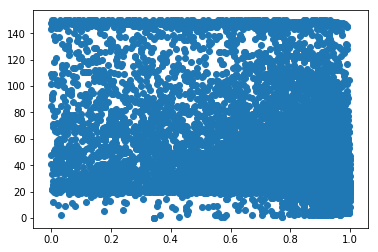

In [48]:
import matplotlib.pyplot
import pylab

matplotlib.pyplot.scatter(u_train_target_abs,train_target_len)

matplotlib.pyplot.show()

In [44]:
#Active transfer learning : Continue training with adding selected samples from target domain
#In this cell, samples where we have the least absolute difference in predicted probability of positive and negative class are added first.


size_model = size_initial
src_key = 'vid'
tgt_key = 'aut'

#Create a sorted version of the certainty, and correspondingly sorted target train set ids, and labels.
sort_ids = np.argsort(u_train_target_abs)
certainty_sorted = u_train_target_abs[sort_ids]
#print(sort_ids)
df_target_ids_pre = dict_transfer_train_ids[tgt_key][src_key]
df_target_labels_pre = dict_train_y[tgt_key]
print('Target labels pre sort',df_target_labels_pre[-20:])
print(type(df_target_labels_pre))
#df_target_ids_pre = df_target_ids_pre.iloc([sort_ids])
df_target_ids = df_target_ids_pre[sort_ids]
df_target_labels = df_target_labels_pre[sort_ids]
print('\n Target labels post sort',df_target_labels[-20:])
print('\n Certainty sorted','\n First 20',certainty_sorted[:20],'\n Last 20',certainty_sorted[-20:])


print('\nTraining on least certain first')
size_list = size_list
for size in size_list:
    avg_certainty = np.average(certainty_sorted[:size])
    print('Training on target sample of size:',size,'with average certainty %0.3f'%avg_certainty)
    tgt_train_df = df_target_ids[:size]
    tgt_train_y = df_target_labels[:size]
    avg_certainty = np.average(certainty_sorted[:size])
    print(tgt_train_df.shape,tgt_train_y.shape)
    continue_transfer_train(src_key,size_model,tgt_key,tgt_train_df,tgt_train_y)

Target labels pre sort [0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1]
<class 'numpy.ndarray'>

 Target labels post sort [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]

 Certainty sorted 
 First 20 [  8.78274441e-05   6.38395548e-04   6.69091940e-04   7.13229179e-04
   7.18593597e-04   9.52094793e-04   1.34050846e-03   1.76942348e-03
   1.81540847e-03   2.14239955e-03   2.14433670e-03   3.23754549e-03
   3.28880548e-03   3.52361798e-03   3.61365080e-03   3.80355120e-03
   4.05833125e-03   4.53045964e-03   5.11655211e-03   5.16593456e-03] 
 Last 20 [ 0.99876553  0.99879622  0.99879766  0.9988389   0.99885935  0.99888998
  0.99896646  0.99910325  0.99918407  0.99921024  0.99922711  0.99925858
  0.99942958  0.99944371  0.99945509  0.99950451  0.99954647  0.99958009
  0.99960864  0.99980825]

Training on least certain first
Training on target sample of size: 2500 with average certainty 0.310
(2500, 150) (2500,)
/home/arunima/fproject/final_project/runs/vid/aut/size_10000/checkpoints
 RESTORING SESSIO

In [50]:
#In this cell, we add samples with the lowest certainty per word id first.
size_model = size_initial
src_key = 'vid'
tgt_key = 'aut'

#Create a sorted version of the certainty, and correspondingly sorted target train set ids, and labels.
sort_ids = np.argsort(c_div_len_target)
c_div_len_sorted = c_div_len_target[sort_ids]
certainty_sorted = u_train_target_abs[sort_ids]
#print(sort_ids)
df_target_ids_pre = dict_transfer_train_ids[tgt_key][src_key]
df_target_labels_pre = dict_train_y[tgt_key]
print('Target labels pre sort',df_target_labels_pre[-20:])
print(type(df_target_labels_pre))
#df_target_ids_pre = df_target_ids_pre.iloc([sort_ids])
df_target_ids = df_target_ids_pre[sort_ids]
df_target_labels = df_target_labels_pre[sort_ids]
print('\n Target labels post sort',df_target_labels[-20:])
print('\n Certainty sorted','\n First 20',certainty_sorted[:20],'\n Last 20',certainty_sorted[-20:])


print('\nTraining on least certain first')
size_list = [2500,5000]
for size in size_list:
    avg_certainty = np.average(certainty_sorted[:size])
    avg_c_div_len = np.average(c_div_len_sorted[:size])
    print('Training on target sample of size:',size,'with average certainty per word id',avg_c_div_len,'with average certainty %0.3f'%avg_certainty)
    tgt_train_df = df_target_ids[:size]
    tgt_train_y = df_target_labels[:size]
    avg_certainty = np.average(certainty_sorted[:size])
    print(tgt_train_df.shape,tgt_train_y.shape)
    continue_transfer_train(src_key,size_model,tgt_key,tgt_train_df,tgt_train_y)

Target labels pre sort [0 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 0 1 1]
<class 'numpy.ndarray'>

 Target labels post sort [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1]

 Certainty sorted 
 First 20 [  8.78274441e-05   6.69091940e-04   7.18593597e-04   7.13229179e-04
   6.38395548e-04   1.81540847e-03   9.52094793e-04   2.14433670e-03
   3.80355120e-03   4.05833125e-03   3.23754549e-03   4.53045964e-03
   1.34050846e-03   3.28880548e-03   5.40760159e-03   3.61365080e-03
   1.76942348e-03   8.53490829e-03   5.43239713e-03   1.02912784e-02] 
 Last 20 [ 0.89449245  0.90011358  0.90871054  0.90871054  0.90871054  0.92040753
  0.92671835  0.9346655   0.93972015  0.96450335  0.96594661  0.96748078
  0.56709552  0.57681489  0.7729829   0.77322745  0.3428182   0.3428182
  0.3428182   0.3428182 ]

Training on least certain first
Training on target sample of size: 2500 with average certainty per word id 0.648237200728 with average certainty 0.417
(2500, 150) (2500,)
/home/arunima/fproject/final_project/runs

In [39]:
#In this cell, samples where we have the most absolute difference in predicted probability of positive and negative class are added first.
size_model = size_initial
print('Training on most certain first')
size_list = size_list
for size in size_list:
    avg_certainty = np.average(certainty_sorted[-size:])
    print('Training on target sample of size:',size,'with average certainty %0.3f'%avg_certainty)
    tgt_train_df = df_target_ids[-size:]
    tgt_train_y = df_target_labels[-size:]
    print(tgt_train_df.shape,tgt_train_y.shape)
    continue_transfer_train(src_key,size_model,tgt_key,tgt_train_df,tgt_train_y)
   

Training on most certain first
Training on target sample of size: 5000 with average certainty 0.998
(5000, 150) (5000,)
/home/arunima/fproject/final_project/runs/vid/aut/size_40000/checkpoints
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /home/arunima/fproject/final_project/runs/vid/aut/size_40000/checkpoints/vidaut_model
 Model loaded from: /home/arunima/fproject/final_project/runs/vid/aut/size_40000/checkpoints/vidaut_model
# batches = 39
Train epoch 0, average loss 0.0311065, average accuracy 0.995793,
		Dev epoch 0, average loss 0.292827, average accuracy 0.8771,
		Dev epoch 0, auc 0.885195, new accuracy 0.8771, right accuracy 0.8771,
				    Time taken for 0 epochs =  72.58204889297485
Train epoch 2, average loss 0.00856757, average accuracy 0.997196,
		Dev epoch 2, average loss 0.277037, average accuracy 0.885753,
		Dev epoch 2, auc 0.883378, new accuracy 0.885753, right accuracy 0.885753,
Train epoch 4, average loss 0.0031396, average a

### Old code that can likely be removed

In [26]:
#Testing only on toys
list_df = ['toys',10000]
for key in list_df:
    print(key)
    train_cnn(key)

toys
completed cnn creation
# batches = 78
Train epoch 0, average loss 0.410732, average accuracy 0.84986,
		Dev epoch 0, average loss 0.384446, average accuracy 0.857337,
		Dev epoch 0, auc 0.761469, new accuracy 0.857337, right accuracy 0.857337,
				    Time taken for 0 epochs =  85.97571444511414
Train epoch 3, average loss 0.278746, average accuracy 0.882512,
Train epoch 6, average loss 0.190353, average accuracy 0.92508,
		Dev epoch 6, average loss 0.267068, average accuracy 0.892323,
		Dev epoch 6, auc 0.884168, new accuracy 0.892323, right accuracy 0.892323,
Train epoch 9, average loss 0.120366, average accuracy 0.963241,
Train epoch 12, average loss 0.0750643, average accuracy 0.983874,
		Dev epoch 12, average loss 0.250142, average accuracy 0.90591,
		Dev epoch 12, auc 0.898789, new accuracy 0.90591, right accuracy 0.90591,
				    Time taken for 12 epochs =  1057.8321163654327
Train epoch 15, average loss 0.0461413, average accuracy 0.995292,
Saved model toys /home/reachanam

In [29]:
#Ak - this seems like a repeat of the previous cell. Not sure it is needed.
size = 10000
for s_key in list_df:
    for t_key in list_df:
        predict_accuracy(s_key, size, t_key)

target vid
source vid
/home/arunima/fproject/final_project/runs/vid/size_10000/checkpoints
INFO:tensorflow:Restoring parameters from /home/arunima/fproject/final_project/runs/vid/size_10000/checkpoints/vid_model
0.857333333333
vid vid AUC 84.74%
vid vid accuracy 85.73%

src_vid_tar_vid_3000 Saved file successfully


In [34]:
#Old version of get_target-data
def get_target_data(key,size = 5000):
    size_train = size #Set size of train set here. This is a hyperparameter.
    #key = list_df[0]
    #print('Toys reviews\n')
    #dict_vectorizers[key] = tflearn.data_utils.VocabularyProcessor(max_length, min_frequency=min_frequency)
    dict_train_df[key], dict_dev_df[key], dict_train_y[key], dict_dev_y[key] = set_df_size(size_train,train_toys,dev_toys)
    dict_train_ids[key], dict_train_y[key],dict_dev_ids[key], dict_dev_ypred[key], dict_vocab_len[key] = process_inputs(key,vocab_processor)
    

In [89]:
get_target_data('vid',2000)

NameError: name 'vocab_processor' is not defined

In [68]:
#initial version of continue train.
#size is needed to get the right source domain file to load
def continue_train(src_key, size, tar_key):
    
    #out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", src_key))
    #out_dir  = os.path.abspath(os.path.join(os.path.curdir, "testruns", src_key))
    
    size_folder =  "size_" + str(size) 
    out_dir  = os.path.abspath(os.path.join(os.path.curdir, "runs", key, size_folder))
    checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))

    
    print(checkpoint_dir)
    src_model = src_key
    #graph_meta_file = checkpoint_dir + '/' + 'hnk01_model.meta'
#     graph_meta_file = checkpoint_dir + '/' + src_model +'01_model.meta'
    graph=tf.Graph()
    
    x_train = dict_train_ids[tar_key]
    y_train = dict_train_y[tar_key]
    x_dev = dict_dev_ids[tar_key]
    y_dev = dict_dev_ypred[tar_key]
    V = dict_vocab_len[tar_key]
    
    
    with graph.as_default():
        with tf.Session() as sess:           
            cnn = TextCNN(sequence_length=x_train.shape[1], num_classes=num_classes, vocab_size=V, learning_rate = learning_rate,
                        momentum = momentum, embedding_size=embed_dim, gl_embed = hands.W, filter_sizes= filter_sizes, 
                      num_filters=num_filters, l2_reg_lambda=l2_reg_lambda)
            
            sess.run(tf.global_variables_initializer())
 
            saver = tf.train.Saver()
    
          #new_saver = tf.train.import_meta_graph(checkpoint_dir/'hnk_model.meta')
#             new_saver = tf.train.import_meta_graph(graph_meta_file)
#             new_saver.restore(sess, tf.train.latest_checkpoint(checkpoint_dir))
            
            
            #initializing weights from a previous session 
            initialising_model = src_model+'_model'
            print(" RESTORING SESSION FOR WEIGHTS INITIALIZATION")
            # Exclude output layer weights from variables we will restore
            variables_to_restore = [v for v in tf.global_variables()]
            # Replace variables scope with that of the current model
            loader = tf.train.Saver({v.op.name.replace(src_model, initialising_model): v for v in variables_to_restore})
            load_path = checkpoint_dir + '/' + initialising_model 
            #load_path = checkpoint_dir  
            loader.restore(sess, load_path)
            print(" Model loaded from: " + load_path) 
            print('# batches =', len(x_train)//batch_size)
            start = time.time()
           
            for e in range(num_epochs):
                    
                #sum_scores = np.zeros((batch_size*(len(x_train)//batch_size),1))
                total_loss = 0
                total_acc = 0
                total_auc = 0
                for i, (x, y) in enumerate(batch_generator(x_train, y_train, batch_size, Trainable=True), 1):
                    feed = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: keep_prob}
                   # _, loss, accuracy, auc = sess.run([cnn.optimizer,cnn.loss, cnn.accuracy, cnn.auc],feed_dict = feed)
                    _, loss, accuracy = sess.run([cnn.optimizer,cnn.loss, cnn.accuracy],feed_dict = feed)
                    total_loss += loss*len(x)
                    total_acc += accuracy*len(x)
                    
                    #total_auc += auc*len(x)
                    
                if e%evaluate_train==0:
                    avg_loss = total_loss/(batch_size*(len(x_train)//batch_size))
                    avg_acc = total_acc/(batch_size*(len(x_train)//batch_size))
                    #avg_auc = total_auc/(batch_size*(len(x_train)//batch_size))
                   # print("Train epoch {}, average loss {:g}, average accuracy {:g},average auc {:g}".format(e, avg_loss, avg_acc, avg_auc))
                    print("Train epoch {}, average loss {:g}, average accuracy {:g},".format(e, avg_loss, avg_acc))

                if e%evaluate_dev==0:
                    
                    total_loss = 0
                    total_acc = 0
                    num_batches = 0
                    total_auc = 0
                    y_pred = []
                    y_pred_proba = []
                    y_shuffled = []
                    total_batch_acc = 0
                    for ii, (x, y) in enumerate(batch_generator(x_dev, y_dev, batch_size, Trainable=False), 1):
                        feed_dict = {cnn.input_x: x, cnn.input_y: y, cnn.dropout_keep_prob: 1.0}
                        #loss, accuracy, auc = sess.run([cnn.loss, cnn.accuracy, cnn.auc],feed_dict)
                       # batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.loss, cnn.accuracy],feed_dict)
                        batch_pred,batch_pred_proba,loss, accuracy  = sess.run([cnn.predictions, cnn.pred_proba, cnn.loss, cnn.accuracy],feed_dict)
                        total_loss += loss*len(x)
                        total_acc += accuracy*len(x)
                        
                        batch_accuracy= np.sum(y==batch_pred)/y.shape[0]
                        total_batch_acc += batch_accuracy
                        y_pred= np.concatenate([y_pred, batch_pred])
                        y_pred_proba= np.concatenate([y_pred_proba, batch_pred_proba[:,1]])
                        y_shuffled = np.concatenate([y_shuffled, y])
                        
                        num_batches += 1
                        
                    avg_loss = total_loss/(num_batches*batch_size)
                    avg_acc = total_acc/(num_batches*batch_size)
                    
                    
                    right_acc = total_batch_acc/(num_batches)
                    #avg_auc = total_auc/(num_batches*batch_size)
                    
                   #Calculate Accuracy
                    new_acc = accuracy_score(y_shuffled, y_pred, normalize=True ) 
                     
                    
                    false_pos_rate, true_pos_rate, _ = roc_curve(y_shuffled, y_pred_proba)  
                    roc_auc = auc(false_pos_rate, true_pos_rate)
                    
                #time_str = datetime.datetime.now().isoformat()
                    print("\t\tDev epoch {}, average loss {:g}, average accuracy {:g},".format(e, avg_loss, avg_acc))
                    print("\t\tDev epoch {}, auc {:g}, new accuracy {:g}, right accuracy {:g},".format(e,  roc_auc, new_acc, right_acc))
                    #print("\t\tDev epoch {}, average loss {:g}, average accuracy {:g},average auc {:g}".format(e, avg_loss, avg_acc, avg_auc))
                if e%time_print == 0:
                    end = time.time()
                    print("\t\t\t\t    Time taken for",e,"epochs = ", end-start)
                    


In [69]:
# remeber to cal get_target_data('vid',2000) with the target key and size you want to add to source domain
#then call continue_train with size of src domain file u want to load
continue_train("toys", 10000, "vid")

#for comparison before train toys vid AUC 81.24%
#toys vid accuracy 81.46%

/home/reachanamikasinha/project/runs/toys/size_10000/checkpoints
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /home/reachanamikasinha/project/runs/toys/size_10000/checkpoints/toys_model
 Model loaded from: /home/reachanamikasinha/project/runs/toys/size_10000/checkpoints/toys_model
# batches = 15
Train epoch 0, average loss 0.0276176, average accuracy 0.996875,
		Dev epoch 0, average loss 0.232405, average accuracy 0.910156,
		Dev epoch 0, auc 0.919749, new accuracy 0.910156, right accuracy 0.910156,
				    Time taken for 0 epochs =  15.348036289215088
Train epoch 3, average loss 0.0183418, average accuracy 1,
Train epoch 6, average loss 0.0133835, average accuracy 1,
		Dev epoch 6, average loss 0.238629, average accuracy 0.908203,
		Dev epoch 6, auc 0.9181, new accuracy 0.908203, right accuracy 0.908203,
Train epoch 9, average loss 0.0105111, average accuracy 1,
Train epoch 12, average loss 0.00948409, average accuracy 1,
		Dev epoch 12, aver

Train results 

toys(10000)
completed cnn creation
# batches = 78
Train epoch 0, average loss 0.410732, average accuracy 0.84986,
		Dev epoch 0, average loss 0.384446, average accuracy 0.857337,
		Dev epoch 0, auc 0.761469, new accuracy 0.857337, right accuracy 0.857337,
				    Time taken for 0 epochs =  85.97571444511414
Train epoch 3, average loss 0.278746, average accuracy 0.882512,
Train epoch 6, average loss 0.190353, average accuracy 0.92508,
		Dev epoch 6, average loss 0.267068, average accuracy 0.892323,
		Dev epoch 6, auc 0.884168, new accuracy 0.892323, right accuracy 0.892323,
Train epoch 9, average loss 0.120366, average accuracy 0.963241,
Train epoch 12, average loss 0.0750643, average accuracy 0.983874,
		Dev epoch 12, average loss 0.250142, average accuracy 0.90591,
		Dev epoch 12, auc 0.898789, new accuracy 0.90591, right accuracy 0.90591,
				    Time taken for 12 epochs =  1057.8321163654327
Train epoch 15, average loss 0.0461413, average accuracy 0.995292,
Saved model toys /home/reachanamikasinha/project/testruns/toys/checkpoints/toys01_model

Continue train 
toys(2000)
# batches = 15
Train epoch 0, average loss 0.0328055, average accuracy 0.998958,
		Dev epoch 0, average loss 0.253235, average accuracy 0.900391,
		Dev epoch 0, auc 0.902401, new accuracy 0.900391, right accuracy 0.900391,
				    Time taken for 0 epochs =  15.97208309173584
Train epoch 3, average loss 0.0209501, average accuracy 1,
Train epoch 6, average loss 0.0157637, average accuracy 1,
		Dev epoch 6, average loss 0.246794, average accuracy 0.910156,
		Dev epoch 6, auc 0.904086, new accuracy 0.910156, right accuracy 0.910156,
Train epoch 9, average loss 0.0133948, average accuracy 0.999479,
Train epoch 12, average loss 0.0110164, average accuracy 1,
		Dev epoch 12, average loss 0.268596, average accuracy 0.900391,
		Dev epoch 12, auc 0.903477, new accuracy 0.900391, right accuracy 0.900391,
				    Time taken for 12 epochs =  203.32078433036804
Train epoch 15, average loss 0.00984509, average accuracy 1,


Continue train 
toys(4000)
/home/reachanamikasinha/project/testruns/toys/checkpoints
 RESTORING SESSION FOR WEIGHTS INITIALIZATION
INFO:tensorflow:Restoring parameters from /home/reachanamikasinha/project/testruns/toys/checkpoints/toys01_model
 Model loaded from: /home/reachanamikasinha/project/testruns/toys/checkpoints/toys01_model
# batches = 31
Train epoch 0, average loss 0.0316445, average accuracy 0.997732,
		Dev epoch 0, average loss 0.238046, average accuracy 0.911458,
		Dev epoch 0, auc 0.915253, new accuracy 0.911458, right accuracy 0.911458,
				    Time taken for 0 epochs =  33.795907497406006
Train epoch 3, average loss 0.021633, average accuracy 0.999748,
Train epoch 6, average loss 0.0158767, average accuracy 0.999496,
		Dev epoch 6, average loss 0.272812, average accuracy 0.903646,
		Dev epoch 6, auc 0.915281, new accuracy 0.903646, right accuracy 0.903646,
Train epoch 9, average loss 0.0130432, average accuracy 0.999748,
Train epoch 12, average loss 0.0109889, average accuracy 1,
		Dev epoch 12, average loss 0.275246, average accuracy 0.908854,
		Dev epoch 12, auc 0.91456, new accuracy 0.908854, right accuracy 0.908854,
				    Time taken for 12 epochs =  418.0527718067169
Train epoch 15, average loss 0.0100661, average accuracy 0.999748,
Train epoch 18, average loss 0.00892393, average accuracy 1,
		Dev epoch 18, average loss 0.276631, average accuracy 0.907986,
		Dev epoch 18, auc 0.915397, new accuracy 0.907986, right accuracy 0.907986,
Train epoch 21, average loss 0.00748347, average accuracy 1,

## Results of transfer learning testing

Comparison
target vid
/home/reachanamikasinha/project/runs/toys/checkpoints
INFO:tensorflow:Restoring parameters from /home/reachanamikasinha/project/runs/toys/checkpoints/toys01_model
0.814630681818
toys vid AUC 81.24%
toys vid accuracy 81.46%

Transfer accuracy source toys, target vid(source trained on 10,000 and 
auc 0.893548, new accuracy 0.898438

# Saving output of model saved run to be able to compare dev accuracy

# toys

completed cnn creation
#batches = 1562
Train epoch 0, average loss 0.281697, average accuracy 0.886964,
		Dev epoch 0, average loss 0.244123, average accuracy 0.908854,
				    Time taken for 0 epochs =  37.60847544670105
Train epoch 3, average loss 0.142607, average accuracy 0.944032,
Train epoch 6, average loss 0.0771984, average accuracy 0.971111,
		Dev epoch 6, average loss 0.234148, average accuracy 0.925581,
Train epoch 9, average loss 0.0413356, average accuracy 0.985665,
Train epoch 12, average loss 0.0262069, average accuracy 0.991207,
		Dev epoch 12, average loss 0.259911, average accuracy 0.931858,
				    Time taken for 12 epochs =  458.23175573349
Train epoch 15, average loss 0.0191853, average accuracy 0.994008,
Train epoch 18, average loss 0.0141925, average accuracy 0.995569,
		Dev epoch 18, average loss 0.297451, average accuracy 0.932759,
Train epoch 21, average loss 0.0111091, average accuracy 0.996669,
Train epoch 24, average loss 0.00874389, average accuracy 0.997289,
		Dev epoch 24, average loss 0.37409, average accuracy 0.930889,
				    Time taken for 24 epochs =  879.0003838539124
Train epoch 27, average loss 0.00864632, average accuracy 0.997309,
Train epoch 30, average loss 0.00784798, average accuracy 0.997459,
		Dev epoch 30, average loss 0.358449, average accuracy 0.932192,
Train epoch 33, average loss 0.00659365, average accuracy 0.997819,
Train epoch 36, average loss 0.00578367, average accuracy 0.998349,
		Dev epoch 36, average loss 0.373084, average accuracy 0.931958,
				    Time taken for 36 epochs =  1299.6440062522888
Train epoch 39, average loss 0.0064537, average accuracy 0.998089,
Train epoch 42, average loss 0.00580202, average accuracy 0.998259,
		Dev epoch 42, average loss 0.391404, average accuracy 0.933393,
Train epoch 45, average loss 0.00514404, average accuracy 0.99845,
Train epoch 48, average loss 0.00371194, average accuracy 0.99892,
		Dev epoch 48, average loss 0.469131, average accuracy 0.931457,
				    Time taken for 48 epochs =  1720.3404235839844
Train epoch 51, average loss 0.0041625, average accuracy 0.99878,
Train epoch 54, average loss 0.00460097, average accuracy 0.99856,
		Dev epoch 54, average loss 0.412365, average accuracy 0.934195,
Train epoch 57, average loss 0.00364978, average accuracy 0.99895,
Saved model toys /home/ubuntu/project/runs/cnn/checkpoints/toys_model

# vid
completed cnn creation
#batches = 1562
Train epoch 0, average loss 0.364666, average accuracy 0.84355,
		Dev epoch 0, average loss 0.319497, average accuracy 0.86071,
				    Time taken for 0 epochs =  37.799813985824585
Train epoch 3, average loss 0.205366, average accuracy 0.917043,
Train epoch 6, average loss 0.121604, average accuracy 0.952835,
		Dev epoch 6, average loss 0.270975, average accuracy 0.899272,
Train epoch 9, average loss 0.07385, average accuracy 0.972371,
Train epoch 12, average loss 0.0478919, average accuracy 0.982955,
		Dev epoch 12, average loss 0.35926, average accuracy 0.8959,
				    Time taken for 12 epochs =  459.7377371788025
Train epoch 15, average loss 0.0352903, average accuracy 0.987636,
Train epoch 18, average loss 0.0294105, average accuracy 0.989997,
		Dev epoch 18, average loss 0.453399, average accuracy 0.899439,
Train epoch 21, average loss 0.0230395, average accuracy 0.992167,
Train epoch 24, average loss 0.021058, average accuracy 0.992928,
		Dev epoch 24, average loss 0.537794, average accuracy 0.899773,
				    Time taken for 24 epochs =  881.6988339424133
Train epoch 27, average loss 0.0175359, average accuracy 0.994248,
Train epoch 30, average loss 0.0139743, average accuracy 0.995549,
		Dev epoch 30, average loss 0.571489, average accuracy 0.899673,
Train epoch 33, average loss 0.0134842, average accuracy 0.995739,
Train epoch 36, average loss 0.0106022, average accuracy 0.996829,
		Dev epoch 36, average loss 0.609015, average accuracy 0.900407,
				    Time taken for 36 epochs =  1303.694475889206
Train epoch 39, average loss 0.0102687, average accuracy 0.996589,
Train epoch 42, average loss 0.00967124, average accuracy 0.997099,
		Dev epoch 42, average loss 0.639956, average accuracy 0.900174,
Train epoch 45, average loss 0.00792713, average accuracy 0.997689,
Train epoch 48, average loss 0.00804649, average accuracy 0.997559,
		Dev epoch 48, average loss 0.696189, average accuracy 0.899272,
				    Time taken for 48 epochs =  1725.6383044719696
Train epoch 51, average loss 0.00929602, average accuracy 0.997259,
Train epoch 54, average loss 0.0067116, average accuracy 0.998039,
		Dev epoch 54, average loss 0.606182, average accuracy 0.900007,
Train epoch 57, average loss 0.00869572, average accuracy 0.997289,
Saved model vid /home/ubuntu/project/runs/cnn/checkpoints/vid_model

# For 100,000 rows
## Output of predict on source domain toys
Target toys


## Output of predict on source domainvid

## KEEPING TRACK OF RESULTS FROM DIFFERENT RUNS
#### Number samples = 10000, Number batches = 156, Without pre-trained embeddings, no dropout
Train epoch 0, loss 0.357085, average loss 0.440941, acc 0.84375, average acc 0.845152,
	Dev epoch 0, loss 0.494501, average loss 0.394619, acc 0.78125, average acc 0.854959,
		Time taken for 0 epochs =  36.18872332572937
Train epoch 2, loss 0.25934, average loss 0.335786, acc 0.875, average acc 0.862079,
Train epoch 4, loss 0.214457, average loss 0.263726, acc 0.875, average acc 0.891827,
Train epoch 6, loss 0.161232, average loss 0.194851, acc 0.890625, average acc 0.92528,
Train epoch 8, loss 0.0968393, average loss 0.132971, acc 0.984375, average acc 0.958133,
Train epoch 10, loss 0.0598382, average loss 0.0935878, acc 1, average acc 0.978766,
	Dev epoch 10, loss 0.318434, average loss 0.279314, acc 0.875, average acc 0.891304,
		Time taken for 10 epochs =  366.54717350006104
Train epoch 12, loss 0.0432213, average loss 0.089715, acc 1, average acc 0.979768,
Train epoch 14, loss 0.0724975, average loss 0.299487, acc 1, average acc 0.957933,
Train epoch 16, loss 0.0388074, average loss 0.0520482, acc 1, average acc 0.991987,
Train epoch 18, loss 0.0239645, average loss 0.0351604, acc 1, average acc 0.997196,
Train epoch 20, loss 0.0157139, average loss 0.0272624, acc 1, average acc 0.996595,
	Dev epoch 20, loss 0.304895, average loss 0.283551, acc 0.921875, average acc 0.902853,
		Time taken for 20 epochs =  697.680163860321
Train epoch 22, loss 0.0131277, average loss 0.017179, acc 1, average acc 0.999299,
Train epoch 24, loss 0.0104588, average loss 0.0121853, acc 1, average acc 0.9999,
Train epoch 26, loss 0.0072446, average loss 0.00969622, acc 1, average acc 0.9999,
Train epoch 28, loss 0.00628954, average loss 0.00805781, acc 1, average acc 0.9999,
Train epoch 30, loss 0.00585206, average loss 0.00689346, acc 1, average acc 0.9999,
	Dev epoch 30, loss 0.37002, average loss 0.327092, acc 0.875, average acc 0.902514,
		Time taken for 30 epochs =  1029.1201057434082
Train epoch 32, loss 0.00559655, average loss 0.00594074, acc 1, average acc 0.9999,
Train epoch 34, loss 0.0053231, average loss 0.00518374, acc 1, average acc 1,
Train epoch 36, loss 0.00504235, average loss 0.00461033, acc 1, average acc 1,
Train epoch 38, loss 0.00477842, average loss 0.00416377, acc 1, average acc 1,
Train epoch 40, loss 0.00451324, average loss 0.00380536, acc 1, average acc 1,
	Dev epoch 40, loss 0.451459, average loss 0.382435, acc 0.859375, average acc 0.899796,
		Time taken for 40 epochs =  1360.2103555202484
        
        
#### Number samples = 10000, Number batches = 156, With pre-trained embeddings(Trainable = False), dropout = 0.8
Train epoch 0, average loss 0.819034, average acc 0.802784,
	Dev epoch 0, average loss 0.415172, average acc 0.853601,
		Time taken for 0 epochs =  35.559093713760376
Train epoch 2, average loss 0.403757, average acc 0.841046,
Train epoch 4, average loss 0.340479, average acc 0.860777,
	Dev epoch 5, average loss 0.329067, average acc 0.867188,
Train epoch 6, average loss 0.289147, average acc 0.882312,
Train epoch 8, average loss 0.237817, average acc 0.904948,
Train epoch 10, average loss 0.194272, average acc 0.923978,
	Dev epoch 10, average loss 0.330927, average acc 0.876698,
		Time taken for 10 epochs =  363.92726016044617
Train epoch 12, average loss 0.149883, average acc 0.940405,
Train epoch 14, average loss 0.128152, average acc 0.951322,
	Dev epoch 15, average loss 0.349508, average acc 0.877717,
Train epoch 16, average loss 0.101319, average acc 0.961639,
Train epoch 18, average loss 0.079585, average acc 0.970052,
Train epoch 20, average loss 0.0705579, average acc 0.97516,
	Dev epoch 20, average loss 0.364253, average acc 0.878057,
		Time taken for 20 epochs =  692.3398864269257
Train epoch 22, average loss 0.0631964, average acc 0.978466,
Train epoch 24, average loss 0.0484077, average acc 0.984876,
	Dev epoch 25, average loss 0.435054, average acc 0.877717,
Train epoch 26, average loss 0.0433892, average acc 0.985377,
Train epoch 28, average loss 0.0368327, average acc 0.988381,
Train epoch 30, average loss 0.0308169, average acc 0.990385,
	Dev epoch 30, average loss 0.570798, average acc 0.875679,
		Time taken for 30 epochs =  1052.273297548294
Train epoch 32, average loss 0.0291807, average acc 0.991086,
Train epoch 34, average loss 0.0271599, average acc 0.991987,
	Dev epoch 35, average loss 0.661539, average acc 0.87534,
Train epoch 36, average loss 0.029594, average acc 0.991486,
Train epoch 38, average loss 0.0236557, average acc 0.99359,
Train epoch 40, average loss 0.018746, average acc 0.995292,
	Dev epoch 40, average loss 0.506544, average acc 0.878397,
		Time taken for 40 epochs =  1466.0729427337646
        
        
#### Changes. Changed convolutional layer weights to xavier initialization. Added random see = 42 to train-test split. Dropped learning rate initial to 0.007

Train epoch 0, average loss 0.399899, average accuracy 0.858273,
	Dev epoch 0, average loss 0.374428, average accuracy 0.857337,
		Time taken for 0 epochs =  34.83389401435852
Train epoch 2, average loss 0.326706, average accuracy 0.869391,
Train epoch 4, average loss 0.269826, average accuracy 0.891126,
	Dev epoch 5, average loss 0.303238, average accuracy 0.88519,
Train epoch 6, average loss 0.219368, average accuracy 0.911659,
Train epoch 8, average loss 0.171234, average accuracy 0.935296,
Train epoch 10, average loss 0.13296, average accuracy 0.953325,
	Dev epoch 10, average loss 0.293018, average accuracy 0.887568,
		Time taken for 10 epochs =  370.47870922088623
Train epoch 12, average loss 0.100562, average accuracy 0.967348,
Train epoch 14, average loss 0.0793127, average accuracy 0.977063,
	Dev epoch 15, average loss 0.320119, average accuracy 0.886209,
Train epoch 16, average loss 0.0582729, average accuracy 0.988482,
Train epoch 18, average loss 0.0456755, average accuracy 0.990385,
Train epoch 20, average loss 0.0405185, average accuracy 0.992788,
	Dev epoch 20, average loss 0.321604, average accuracy 0.886889,
		Time taken for 20 epochs =  705.0958936214447
Train epoch 22, average loss 0.0351258, average accuracy 0.993089,
Train epoch 24, average loss 0.0270392, average accuracy 0.996194,
	Dev epoch 25, average loss 0.399808, average accuracy 0.884171,
Train epoch 26, average loss 0.0262923, average accuracy 0.995994,
Train epoch 28, average loss 0.0242657, average accuracy 0.995994,
Train epoch 30, average loss 0.0208821, average accuracy 0.996394,
	Dev epoch 30, average loss 0.413923, average accuracy 0.886889,
		Time taken for 30 epochs =  1039.4113600254059
Train epoch 32, average loss 0.017492, average accuracy 0.997696,
Train epoch 34, average loss 0.0146527, average accuracy 0.998097,
	Dev epoch 35, average loss 0.386267, average accuracy 0.884851,
Train epoch 36, average loss 0.0168233, average accuracy 0.997396,
Train epoch 38, average loss 0.0142984, average accuracy 0.997796,
Train epoch 40, average loss 0.0110543, average accuracy 0.998998,
	Dev epoch 40, average loss 0.478341, average accuracy 0.884171,
		Time taken for 40 epochs =  1374.086744070053
Train epoch 42, average loss 0.012298, average accuracy 0.998397,
Train epoch 44, average loss 0.0116889, average accuracy 0.998197,
	Dev epoch 45, average loss 0.448394, average accuracy 0.88587,
Train epoch 46, average loss 0.0107089, average accuracy 0.998197,
Train epoch 48, average loss 0.00953887, average accuracy 0.998898,
Train epoch 50, average loss 0.0097256, average accuracy 0.998898,
	Dev epoch 50, average loss 0.424627, average accuracy 0.886209,
		Time taken for 50 epochs =  1708.131004333496
Train epoch 52, average loss 0.00792942, average accuracy 0.999099,
Train epoch 54, average loss 0.00777054, average accuracy 0.999099,
	Dev epoch 55, average loss 0.434766, average accuracy 0.887228,
Train epoch 56, average loss 0.00812112, average accuracy 0.999099,
Train epoch 58, average loss 0.00817043, average accuracy 0.998798,
Train epoch 60, average loss 0.00776972, average accuracy 0.998498,
	Dev epoch 60, average loss 0.447535, average accuracy 0.886889,
		Time taken for 60 epochs =  2042.1303217411041
Train epoch 62, average loss 0.00759579, average accuracy 0.998998,
Train epoch 64, average loss 0.00697335, average accuracy 0.998798,
	Dev epoch 65, average loss 0.514295, average accuracy 0.88519,
Train epoch 66, average loss 0.00579109, average accuracy 0.999199,
Train epoch 68, average loss 0.00583337, average accuracy 0.999499,

#### Changes. set trainable = True in glove embeddings. Changed learning rate back to 0.01 initial.
# batches = 156
Train epoch 0, average loss 0.399899, average accuracy 0.858273,
	Dev epoch 0, average loss 0.374428, average accuracy 0.857337,
		Time taken for 0 epochs =  34.83389401435852
Train epoch 2, average loss 0.326706, average accuracy 0.869391,
Train epoch 4, average loss 0.269826, average accuracy 0.891126,
	Dev epoch 5, average loss 0.303238, average accuracy 0.88519,
Train epoch 6, average loss 0.219368, average accuracy 0.911659,
Train epoch 8, average loss 0.171234, average accuracy 0.935296,
Train epoch 10, average loss 0.13296, average accuracy 0.953325,
	Dev epoch 10, average loss 0.293018, average accuracy 0.887568,
		Time taken for 10 epochs =  370.47870922088623
Train epoch 12, average loss 0.100562, average accuracy 0.967348,
Train epoch 14, average loss 0.0793127, average accuracy 0.977063,
	Dev epoch 15, average loss 0.320119, average accuracy 0.886209,
Train epoch 16, average loss 0.0582729, average accuracy 0.988482,
Train epoch 18, average loss 0.0456755, average accuracy 0.990385,
Train epoch 20, average loss 0.0405185, average accuracy 0.992788,
	Dev epoch 20, average loss 0.321604, average accuracy 0.886889,
		Time taken for 20 epochs =  705.0958936214447
Train epoch 22, average loss 0.0351258, average accuracy 0.993089,
Train epoch 24, average loss 0.0270392, average accuracy 0.996194,
	Dev epoch 25, average loss 0.399808, average accuracy 0.884171,
Train epoch 26, average loss 0.0262923, average accuracy 0.995994,
Train epoch 28, average loss 0.0242657, average accuracy 0.995994,
Train epoch 30, average loss 0.0208821, average accuracy 0.996394,
	Dev epoch 30, average loss 0.413923, average accuracy 0.886889,
		Time taken for 30 epochs =  1039.4113600254059
Train epoch 32, average loss 0.017492, average accuracy 0.997696,
Train epoch 34, average loss 0.0146527, average accuracy 0.998097,
	Dev epoch 35, average loss 0.386267, average accuracy 0.884851,
Train epoch 36, average loss 0.0168233, average accuracy 0.997396,
Train epoch 38, average loss 0.0142984, average accuracy 0.997796,
Train epoch 40, average loss 0.0110543, average accuracy 0.998998,
	Dev epoch 40, average loss 0.478341, average accuracy 0.884171,
		Time taken for 40 epochs =  1374.086744070053
Train epoch 42, average loss 0.012298, average accuracy 0.998397,
Train epoch 44, average loss 0.0116889, average accuracy 0.998197,
	Dev epoch 45, average loss 0.448394, average accuracy 0.88587,
Train epoch 46, average loss 0.0107089, average accuracy 0.998197,
Train epoch 48, average loss 0.00953887, average accuracy 0.998898,
Train epoch 50, average loss 0.0097256, average accuracy 0.998898,
	Dev epoch 50, average loss 0.424627, average accuracy 0.886209,
		Time taken for 50 epochs =  1708.131004333496
Train epoch 52, average loss 0.00792942, average accuracy 0.999099,
Train epoch 54, average loss 0.00777054, average accuracy 0.999099,
	Dev epoch 55, average loss 0.434766, average accuracy 0.887228,
Train epoch 56, average loss 0.00812112, average accuracy 0.999099,
Train epoch 58, average loss 0.00817043, average accuracy 0.998798,
Train epoch 60, average loss 0.00776972, average accuracy 0.998498,
	Dev epoch 60, average loss 0.447535, average accuracy 0.886889,
		Time taken for 60 epochs =  2042.1303217411041
Train epoch 62, average loss 0.00759579, average accuracy 0.998998,
Train epoch 64, average loss 0.00697335, average accuracy 0.998798,
	Dev epoch 65, average loss 0.514295, average accuracy 0.88519,
Train epoch 66, average loss 0.00579109, average accuracy 0.999199,
Train epoch 68, average loss 0.00583337, average accuracy 0.999499,


#### Changes : increased sample size to 20000. increased filter number to 256 per filter size. Both together slowed it down 4 times. Ran 150 epochs.

Result - get to accuracy of about 90.5% on dev set. First saw it in about 80 epochs.

number of batches = 312
Train epoch 0, average loss 0.399409, average accuracy 0.851763,
	Dev epoch 0, average loss 0.390935, average accuracy 0.849798,
		Time taken for 0 epochs =  126.17049622535706
Train epoch 2, average loss 0.310082, average accuracy 0.877955,
Train epoch 4, average loss 0.240321, average accuracy 0.905298,
	Dev epoch 5, average loss 0.309063, average accuracy 0.879872,
Train epoch 6, average loss 0.183422, average accuracy 0.929137,
Train epoch 8, average loss 0.132305, average accuracy 0.950871,
Train epoch 10, average loss 0.091186, average accuracy 0.96855,
	Dev epoch 10, average loss 0.359275, average accuracy 0.887769,
		Time taken for 10 epochs =  1301.3605210781097
Train epoch 12, average loss 0.0655771, average accuracy 0.978966,
Train epoch 14, average loss 0.0487824, average accuracy 0.986579,
	Dev epoch 15, average loss 0.31907, average accuracy 0.901546,
Train epoch 16, average loss 0.0353836, average accuracy 0.991136,
Train epoch 18, average loss 0.0272109, average accuracy 0.993389,
Train epoch 20, average loss 0.0209386, average accuracy 0.995843,
	Dev epoch 20, average loss 0.473887, average accuracy 0.888609,
		Time taken for 20 epochs =  2475.8890883922577
Train epoch 22, average loss 0.0169513, average accuracy 0.996444,
Train epoch 24, average loss 0.0144857, average accuracy 0.997045,
	Dev epoch 25, average loss 0.52256, average accuracy 0.886929,
Train epoch 26, average loss 0.0115876, average accuracy 0.998147,
Train epoch 28, average loss 0.00961356, average accuracy 0.998347,
Train epoch 30, average loss 0.00915859, average accuracy 0.998297,
	Dev epoch 30, average loss 0.458756, average accuracy 0.895665,
		Time taken for 30 epochs =  3649.31303191185
Train epoch 32, average loss 0.00898325, average accuracy 0.998498,
Train epoch 34, average loss 0.00841926, average accuracy 0.998448,
	Dev epoch 35, average loss 0.457308, average accuracy 0.897681,
Train epoch 36, average loss 0.00646681, average accuracy 0.999149,
Train epoch 38, average loss 0.00662382, average accuracy 0.998598,
Train epoch 40, average loss 0.00595506, average accuracy 0.999149,
	Dev epoch 40, average loss 0.378182, average accuracy 0.901546,
		Time taken for 40 epochs =  4823.336989402771
Train epoch 42, average loss 0.00593351, average accuracy 0.999149,
Train epoch 44, average loss 0.00464219, average accuracy 0.999249,
	Dev epoch 45, average loss 0.431081, average accuracy 0.90121,
Train epoch 46, average loss 0.00444085, average accuracy 0.999499,
Train epoch 48, average loss 0.00461485, average accuracy 0.999349,
Train epoch 50, average loss 0.00466378, average accuracy 0.999199,
	Dev epoch 50, average loss 0.380632, average accuracy 0.90289,
		Time taken for 50 epochs =  5997.558866024017
Train epoch 52, average loss 0.00401276, average accuracy 0.999299,
Train epoch 54, average loss 0.00360064, average accuracy 0.999549,
	Dev epoch 55, average loss 0.472261, average accuracy 0.900706,
Train epoch 56, average loss 0.00390259, average accuracy 0.999449,
Train epoch 58, average loss 0.00343323, average accuracy 0.999499,
Train epoch 60, average loss 0.00328182, average accuracy 0.999549,
	Dev epoch 60, average loss 0.405813, average accuracy 0.901714,
		Time taken for 60 epochs =  7171.330280542374
Train epoch 62, average loss 0.00357674, average accuracy 0.999499,
Train epoch 64, average loss 0.00316356, average accuracy 0.999449,
	Dev epoch 65, average loss 0.484432, average accuracy 0.899698,
Train epoch 66, average loss 0.00242786, average accuracy 0.99975,
Train epoch 68, average loss 0.0029979, average accuracy 0.999399,
Train epoch 70, average loss 0.00219736, average accuracy 0.999599,
	Dev epoch 70, average loss 0.522188, average accuracy 0.89953,
		Time taken for 70 epochs =  8345.40755033493
Train epoch 72, average loss 0.00263028, average accuracy 0.999599,
Train epoch 74, average loss 0.00262097, average accuracy 0.999599,
	Dev epoch 75, average loss 0.501381, average accuracy 0.90037,
Train epoch 76, average loss 0.00184087, average accuracy 0.99975,
Train epoch 78, average loss 0.00261343, average accuracy 0.999399,
Train epoch 80, average loss 0.00210662, average accuracy 0.9997,
	Dev epoch 80, average loss 0.437249, average accuracy 0.90457,
		Time taken for 80 epochs =  9519.476462364197
Train epoch 82, average loss 0.00218873, average accuracy 0.999599,
Train epoch 84, average loss 0.00204953, average accuracy 0.9997,
	Dev epoch 85, average loss 0.440843, average accuracy 0.90457,
Train epoch 86, average loss 0.00178851, average accuracy 0.99975,
Train epoch 88, average loss 0.00177724, average accuracy 0.999599,
Train epoch 90, average loss 0.0018953, average accuracy 0.999599,
	Dev epoch 90, average loss 0.465653, average accuracy 0.905074,
		Time taken for 90 epochs =  10693.68774318695
Train epoch 92, average loss 0.00145395, average accuracy 0.9998,
Train epoch 94, average loss 0.00158429, average accuracy 0.999649,
	Dev epoch 95, average loss 0.472749, average accuracy 0.90541,
Train epoch 96, average loss 0.00238694, average accuracy 0.999499,
Train epoch 98, average loss 0.00175795, average accuracy 0.9997,
Train epoch 100, average loss 0.00153946, average accuracy 0.9998,
	Dev epoch 100, average loss 0.440989, average accuracy 0.906754,
		Time taken for 100 epochs =  11867.341850280762
Train epoch 102, average loss 0.00144569, average accuracy 0.9998,
Train epoch 104, average loss 0.00135836, average accuracy 0.99975,
	Dev epoch 105, average loss 0.450465, average accuracy 0.90457,
Train epoch 106, average loss 0.00134604, average accuracy 0.99985,
Train epoch 108, average loss 0.00198454, average accuracy 0.999549,
Train epoch 110, average loss 0.0016289, average accuracy 0.99975,
	Dev epoch 110, average loss 0.43462, average accuracy 0.905242,
		Time taken for 110 epochs =  13040.53886771202
Train epoch 112, average loss 0.00116808, average accuracy 0.99975,
Train epoch 114, average loss 0.00163431, average accuracy 0.999649,
	Dev epoch 115, average loss 0.544521, average accuracy 0.901714,
Train epoch 116, average loss 0.00107182, average accuracy 0.9999,
Train epoch 118, average loss 0.00118616, average accuracy 0.99985,
Train epoch 120, average loss 0.00116875, average accuracy 0.9998,
	Dev epoch 120, average loss 0.456846, average accuracy 0.906082,
		Time taken for 120 epochs =  14214.848599672318
Train epoch 122, average loss 0.00144058, average accuracy 0.999649,
Train epoch 124, average loss 0.00139588, average accuracy 0.999649,
	Dev epoch 125, average loss 0.456731, average accuracy 0.90709,
Train epoch 126, average loss 0.00129419, average accuracy 0.99975,
Train epoch 128, average loss 0.000993939, average accuracy 0.9998,
Train epoch 130, average loss 0.00110859, average accuracy 0.99975,
	Dev epoch 130, average loss 0.440627, average accuracy 0.905242,
		Time taken for 130 epochs =  15387.949309825897
Train epoch 132, average loss 0.000869354, average accuracy 0.9998,
Train epoch 134, average loss 0.0010678, average accuracy 0.99975,
	Dev epoch 135, average loss 0.662642, average accuracy 0.895497,
Train epoch 136, average loss 0.00121623, average accuracy 0.99985,
Train epoch 138, average loss 0.00106557, average accuracy 0.9998,
Train epoch 140, average loss 0.0012005, average accuracy 0.9997,
	Dev epoch 140, average loss 0.48323, average accuracy 0.905578,
		Time taken for 140 epochs =  16560.915422201157
Train epoch 142, average loss 0.00142349, average accuracy 0.999649,
Train epoch 144, average loss 0.00100832, average accuracy 0.9998,
	Dev epoch 145, average loss 0.469864, average accuracy 0.906082,
Train epoch 146, average loss 0.000867766, average accuracy 0.99985,
Train epoch 148, average loss 0.000895252, average accuracy 0.9998,
Train epoch 150, average loss 0.00128643, average accuracy 0.99975,
	Dev epoch 150, average loss 0.504558, average accuracy 0.904738,
		Time taken for 150 epochs =  17732.689709424973
Train epoch 152, average loss 0.00106975, average accuracy 0.99975,
Train epoch 154, average loss 0.000923771, average accuracy 0.9998,
	Dev epoch 155, average loss 0.46343, average accuracy 0.904066,
    
    
#### Home and Kitchen, 100000 reviews. 200 epochs, min-documents = 0, embedding size = 100, embeddings trainable = True.

completed cnn creation
Number batches = 1562
Train epoch 0, average loss 0.304591, average accuracy 0.87457,
	Dev epoch 0, average loss 0.237596, average accuracy 0.904013,
		Time taken for 0 epochs =  36.92328929901123
Train epoch 1, average loss 0.223893, average accuracy 0.910071,
Train epoch 2, average loss 0.183924, average accuracy 0.927187,
Train epoch 3, average loss 0.150811, average accuracy 0.941301,
Train epoch 4, average loss 0.123611, average accuracy 0.952775,
Train epoch 5, average loss 0.101681, average accuracy 0.961138,
	Dev epoch 5, average loss 0.215108, average accuracy 0.917234,
Train epoch 6, average loss 0.0824821, average accuracy 0.9694,
Train epoch 7, average loss 0.0682877, average accuracy 0.975272,
Train epoch 8, average loss 0.0581098, average accuracy 0.978353,
Train epoch 9, average loss 0.0481609, average accuracy 0.982815,
Train epoch 10, average loss 0.0426059, average accuracy 0.984625,
	Dev epoch 10, average loss 0.258906, average accuracy 0.918336,
		Time taken for 10 epochs =  381.81759333610535
Train epoch 11, average loss 0.0369901, average accuracy 0.986686,
Train epoch 12, average loss 0.0348868, average accuracy 0.986946,
Train epoch 13, average loss 0.0291087, average accuracy 0.989937,
Train epoch 14, average loss 0.0271577, average accuracy 0.990807,
Train epoch 15, average loss 0.0248202, average accuracy 0.991487,
	Dev epoch 15, average loss 0.317684, average accuracy 0.925114,
Train epoch 16, average loss 0.0232966, average accuracy 0.992037,
Train epoch 17, average loss 0.0218823, average accuracy 0.992578,
Train epoch 18, average loss 0.0189234, average accuracy 0.993878,
Train epoch 19, average loss 0.0175714, average accuracy 0.993978,
Train epoch 20, average loss 0.0175559, average accuracy 0.994108,
	Dev epoch 20, average loss 0.322537, average accuracy 0.924746,
		Time taken for 20 epochs =  727.1127679347992
Train epoch 21, average loss 0.0159045, average accuracy 0.994638,
Train epoch 22, average loss 0.0141158, average accuracy 0.995409,
Train epoch 23, average loss 0.0130852, average accuracy 0.995809,
Train epoch 24, average loss 0.0131137, average accuracy 0.995709,
Train epoch 25, average loss 0.0123618, average accuracy 0.995899,
	Dev epoch 25, average loss 0.403685, average accuracy 0.924646,
Train epoch 26, average loss 0.0112836, average accuracy 0.996369,
Train epoch 27, average loss 0.0111362, average accuracy 0.996449,
Train epoch 28, average loss 0.00865663, average accuracy 0.997299,
Train epoch 29, average loss 0.00935199, average accuracy 0.996959,
Train epoch 30, average loss 0.00935717, average accuracy 0.996699,
	Dev epoch 30, average loss 0.367405, average accuracy 0.924579,
		Time taken for 30 epochs =  1072.1994183063507
Train epoch 31, average loss 0.00909225, average accuracy 0.997149,
Train epoch 32, average loss 0.00754316, average accuracy 0.997819,
Train epoch 33, average loss 0.0079119, average accuracy 0.997379,
Train epoch 34, average loss 0.00705012, average accuracy 0.997719,
Train epoch 35, average loss 0.00730037, average accuracy 0.997829,
	Dev epoch 35, average loss 0.370859, average accuracy 0.926749,
Train epoch 36, average loss 0.00705196, average accuracy 0.997799,
Train epoch 37, average loss 0.00669642, average accuracy 0.998039,
Train epoch 38, average loss 0.00627199, average accuracy 0.998009,
Train epoch 39, average loss 0.00528379, average accuracy 0.998309,
Train epoch 40, average loss 0.00593793, average accuracy 0.998229,
	Dev epoch 40, average loss 0.383177, average accuracy 0.927618,
		Time taken for 40 epochs =  1416.9269080162048
Train epoch 41, average loss 0.00519099, average accuracy 0.998289,
Train epoch 42, average loss 0.00574083, average accuracy 0.998259,
Train epoch 43, average loss 0.00573397, average accuracy 0.998269,
Train epoch 44, average loss 0.00478373, average accuracy 0.99844,
Train epoch 45, average loss 0.00476654, average accuracy 0.99864,
	Dev epoch 45, average loss 0.401872, average accuracy 0.927651,
Train epoch 46, average loss 0.00546603, average accuracy 0.998079,
Train epoch 47, average loss 0.00552262, average accuracy 0.998299,
Train epoch 48, average loss 0.0044039, average accuracy 0.9986,
Train epoch 49, average loss 0.00444202, average accuracy 0.99858,
Train epoch 50, average loss 0.00553655, average accuracy 0.998239,
	Dev epoch 50, average loss 0.410369, average accuracy 0.926182,
		Time taken for 50 epochs =  1761.8077738285065
Train epoch 51, average loss 0.00446012, average accuracy 0.99862,
Train epoch 52, average loss 0.00399219, average accuracy 0.9988,
Train epoch 53, average loss 0.00413133, average accuracy 0.99876,
Train epoch 54, average loss 0.00465115, average accuracy 0.99857,
Train epoch 55, average loss 0.00390704, average accuracy 0.99883,
	Dev epoch 55, average loss 0.523764, average accuracy 0.924212,
Train epoch 56, average loss 0.00380121, average accuracy 0.99894,
Train epoch 57, average loss 0.0041114, average accuracy 0.99863,
Train epoch 58, average loss 0.00400388, average accuracy 0.99874,
Train epoch 59, average loss 0.00436616, average accuracy 0.99868,
Train epoch 60, average loss 0.00410136, average accuracy 0.99879,
	Dev epoch 60, average loss 0.465152, average accuracy 0.926115,
		Time taken for 60 epochs =  2106.424416542053
Train epoch 61, average loss 0.00331209, average accuracy 0.99906,
Train epoch 62, average loss 0.00366131, average accuracy 0.99892,
Train epoch 63, average loss 0.00425752, average accuracy 0.99884,
Train epoch 64, average loss 0.00341706, average accuracy 0.99892,
Train epoch 65, average loss 0.00352085, average accuracy 0.99884,
	Dev epoch 65, average loss 0.443976, average accuracy 0.919404,
Train epoch 66, average loss 0.00392861, average accuracy 0.99874,
Train epoch 67, average loss 0.00390108, average accuracy 0.99879,
Train epoch 68, average loss 0.00344137, average accuracy 0.99892,
Train epoch 69, average loss 0.00282472, average accuracy 0.99918,
Train epoch 70, average loss 0.00305406, average accuracy 0.99906,
	Dev epoch 70, average loss 0.497239, average accuracy 0.926783,
		Time taken for 70 epochs =  2451.336544752121
Train epoch 71, average loss 0.00335245, average accuracy 0.99887,
Train epoch 72, average loss 0.00321827, average accuracy 0.99912,
Train epoch 73, average loss 0.0030572, average accuracy 0.99906,
Train epoch 74, average loss 0.00308252, average accuracy 0.99905,
Train epoch 75, average loss 0.00312562, average accuracy 0.99909,
	Dev epoch 75, average loss 0.454947, average accuracy 0.927818,
Train epoch 76, average loss 0.00308124, average accuracy 0.99912,
Train epoch 77, average loss 0.00282977, average accuracy 0.9991,
Train epoch 78, average loss 0.00250926, average accuracy 0.99929,
Train epoch 79, average loss 0.00278992, average accuracy 0.99917,
Train epoch 80, average loss 0.00226384, average accuracy 0.99932,
	Dev epoch 80, average loss 0.524143, average accuracy 0.925314,
		Time taken for 80 epochs =  2796.155880212784
Train epoch 81, average loss 0.00289398, average accuracy 0.99907,
Train epoch 82, average loss 0.00267882, average accuracy 0.99915,
Train epoch 83, average loss 0.00251234, average accuracy 0.99917,
Train epoch 84, average loss 0.00212931, average accuracy 0.99929,
Train epoch 85, average loss 0.00204477, average accuracy 0.99936,
	Dev epoch 85, average loss 0.533493, average accuracy 0.926382,
Train epoch 86, average loss 0.00236821, average accuracy 0.99926,
Train epoch 87, average loss 0.00237569, average accuracy 0.99921,
Train epoch 88, average loss 0.00245643, average accuracy 0.99923,
Train epoch 89, average loss 0.00226378, average accuracy 0.99937,
Train epoch 90, average loss 0.00233121, average accuracy 0.99925,
	Dev epoch 90, average loss 0.58426, average accuracy 0.924112,
		Time taken for 90 epochs =  3140.9629440307617
Train epoch 91, average loss 0.00239393, average accuracy 0.99934,
Train epoch 92, average loss 0.00168514, average accuracy 0.99947,
Train epoch 93, average loss 0.00218618, average accuracy 0.99934,
Train epoch 94, average loss 0.00201177, average accuracy 0.99939,
Train epoch 95, average loss 0.00265143, average accuracy 0.99903,

	Dev epoch 95, average loss 0.522781, average accuracy 0.927284,
Train epoch 96, average loss 0.00200737, average accuracy 0.99945,
Train epoch 97, average loss 0.00167531, average accuracy 0.99956,
Train epoch 98, average loss 0.00197691, average accuracy 0.99943,
Train epoch 99, average loss 0.00189404, average accuracy 0.99943,
Train epoch 100, average loss 0.00217102, average accuracy 0.99935,
	Dev epoch 100, average loss 0.509596, average accuracy 0.927417,
		Time taken for 100 epochs =  3485.5287368297577
Train epoch 101, average loss 0.00214391, average accuracy 0.99932,
Train epoch 102, average loss 0.00166687, average accuracy 0.99949,
Train epoch 103, average loss 0.00193214, average accuracy 0.99941,
Train epoch 104, average loss 0.00230417, average accuracy 0.99928,
Train epoch 105, average loss 0.00262318, average accuracy 0.99917,
	Dev epoch 105, average loss 0.580702, average accuracy 0.924379,
Train epoch 106, average loss 0.00217951, average accuracy 0.99936,
Train epoch 107, average loss 0.00196965, average accuracy 0.9994,
Train epoch 108, average loss 0.00169252, average accuracy 0.99945,
Train epoch 109, average loss 0.00184972, average accuracy 0.99937,
Train epoch 110, average loss 0.00203432, average accuracy 0.99938,
	Dev epoch 110, average loss 0.580674, average accuracy 0.925214,
		Time taken for 110 epochs =  3830.0551614761353
Train epoch 111, average loss 0.0018848, average accuracy 0.99941,
Train epoch 112, average loss 0.001956, average accuracy 0.99934,
Train epoch 113, average loss 0.00164951, average accuracy 0.99948,
Train epoch 114, average loss 0.00189435, average accuracy 0.99941,
Train epoch 115, average loss 0.00179166, average accuracy 0.99939,
	Dev epoch 115, average loss 0.541616, average accuracy 0.926282,
Train epoch 116, average loss 0.0018286, average accuracy 0.99944,
Train epoch 117, average loss 0.00176589, average accuracy 0.99943,
Train epoch 118, average loss 0.00170349, average accuracy 0.99947,
Train epoch 119, average loss 0.00222146, average accuracy 0.99928,
Train epoch 120, average loss 0.00133639, average accuracy 0.99959,
	Dev epoch 120, average loss 0.587092, average accuracy 0.926482,
		Time taken for 120 epochs =  4174.599865913391
Train epoch 121, average loss 0.00179675, average accuracy 0.99939,
Train epoch 122, average loss 0.00170493, average accuracy 0.99948,
Train epoch 123, average loss 0.00196213, average accuracy 0.99939,
Train epoch 124, average loss 0.00148926, average accuracy 0.99953,
Train epoch 125, average loss 0.00146297, average accuracy 0.99951,
	Dev epoch 125, average loss 0.555345, average accuracy 0.926516,
Train epoch 126, average loss 0.00200696, average accuracy 0.99936,
Train epoch 127, average loss 0.00152734, average accuracy 0.99952,
Train epoch 128, average loss 0.00232658, average accuracy 0.9993,
Train epoch 129, average loss 0.00197241, average accuracy 0.99939,
Train epoch 130, average loss 0.00210397, average accuracy 0.99924,
	Dev epoch 130, average loss 0.670168, average accuracy 0.92291,
		Time taken for 130 epochs =  4519.105709552765
Train epoch 131, average loss 0.00184804, average accuracy 0.99943,
Train epoch 132, average loss 0.00178672, average accuracy 0.99941,
Train epoch 133, average loss 0.00175419, average accuracy 0.9994,
Train epoch 134, average loss 0.0019224, average accuracy 0.99934,
Train epoch 135, average loss 0.00222945, average accuracy 0.99931,
	Dev epoch 135, average loss 0.657096, average accuracy 0.923377,
Train epoch 136, average loss 0.00175209, average accuracy 0.99934,
Train epoch 137, average loss 0.00214912, average accuracy 0.99925,
Train epoch 138, average loss 0.00162636, average accuracy 0.99941,
Train epoch 139, average loss 0.00180691, average accuracy 0.99946,
Train epoch 140, average loss 0.00118666, average accuracy 0.99959,
	Dev epoch 140, average loss 0.575778, average accuracy 0.926015,
		Time taken for 140 epochs =  4863.487067222595
        

#### Same as above, with 60 epochs.

completed cnn creation
Number batches = 1562
Train epoch 0, average loss 0.30547, average accuracy 0.87393,
	Dev epoch 0, average loss 0.237115, average accuracy 0.904915,
		Time taken for 0 epochs =  36.875508308410645
Train epoch 3, average loss 0.152626, average accuracy 0.940681,
Train epoch 6, average loss 0.0826888, average accuracy 0.96937,
	Dev epoch 6, average loss 0.237618, average accuracy 0.921307,
Train epoch 9, average loss 0.0498599, average accuracy 0.982274,
Train epoch 12, average loss 0.0340667, average accuracy 0.987906,
	Dev epoch 12, average loss 0.290549, average accuracy 0.922075,
		Time taken for 12 epochs =  449.51883339881897
Train epoch 15, average loss 0.0254497, average accuracy 0.991217,
Train epoch 18, average loss 0.0187158, average accuracy 0.993648,
	Dev epoch 18, average loss 0.306756, average accuracy 0.923945,
Train epoch 21, average loss 0.0152883, average accuracy 0.995038,
Train epoch 24, average loss 0.0124834, average accuracy 0.995999,
	Dev epoch 24, average loss 0.329978, average accuracy 0.926716,
		Time taken for 24 epochs =  862.4385898113251
Train epoch 27, average loss 0.0112456, average accuracy 0.996409,
Train epoch 30, average loss 0.00972575, average accuracy 0.996939,
	Dev epoch 30, average loss 0.361886, average accuracy 0.92695,
Train epoch 33, average loss 0.00892223, average accuracy 0.997189,
Train epoch 36, average loss 0.00712946, average accuracy 0.997789,
	Dev epoch 36, average loss 0.381359, average accuracy 0.92685,
		Time taken for 36 epochs =  1275.2902917861938
Train epoch 39, average loss 0.00628213, average accuracy 0.998139,
Train epoch 42, average loss 0.00596454, average accuracy 0.998159,
	Dev epoch 42, average loss 0.47203, average accuracy 0.924446,
Train epoch 45, average loss 0.00500223, average accuracy 0.9985,
Train epoch 48, average loss 0.00469857, average accuracy 0.99864,
	Dev epoch 48, average loss 0.401148, average accuracy 0.926749,
		Time taken for 48 epochs =  1688.264419078827
Train epoch 51, average loss 0.00402232, average accuracy 0.99886,
Train epoch 54, average loss 0.00421826, average accuracy 0.99865,
	Dev epoch 54, average loss 0.416046, average accuracy 0.928385,
Train epoch 57, average loss 0.00368313, average accuracy 0.99893,
Train epoch 60, average loss 0.00335348, average accuracy 0.99901,
	Dev epoch 60, average loss 0.438822, average accuracy 0.927918,
		Time taken for 60 epochs =  2101.384346008301

#### With the embeddings set to trainable = false.
completed cnn creation
# batches = 1562
Train epoch 0, average loss 0.304837, average accuracy 0.87436,
		Dev epoch 0, average loss 0.239171, average accuracy 0.905649,
				    Time taken for 0 epochs =  33.351370334625244
Train epoch 3, average loss 0.159725, average accuracy 0.93797,
Train epoch 6, average loss 0.0951332, average accuracy 0.963478,
		Dev epoch 6, average loss 0.222475, average accuracy 0.916299,
Train epoch 9, average loss 0.0597436, average accuracy 0.978053,
Train epoch 12, average loss 0.0414887, average accuracy 0.985045,
		Dev epoch 12, average loss 0.258621, average accuracy 0.921708,
				    Time taken for 12 epochs =  405.9028522968292
Train epoch 15, average loss 0.03174, average accuracy 0.988536,
Train epoch 18, average loss 0.0268379, average accuracy 0.990747,
		Dev epoch 18, average loss 0.308509, average accuracy 0.922242,
Train epoch 21, average loss 0.0237158, average accuracy 0.991737,
Train epoch 24, average loss 0.0182942, average accuracy 0.993528,
		Dev epoch 24, average loss 0.330288, average accuracy 0.922643,
				    Time taken for 24 epochs =  778.5845618247986
Train epoch 27, average loss 0.0170312, average accuracy 0.994198,
Train epoch 30, average loss 0.0140965, average accuracy 0.994978,
		Dev epoch 30, average loss 0.389294, average accuracy 0.922476,
Train epoch 33, average loss 0.0119405, average accuracy 0.996029,
Train epoch 36, average loss 0.0102918, average accuracy 0.996929,
		Dev epoch 36, average loss 0.390921, average accuracy 0.922943,
				    Time taken for 36 epochs =  1150.900290966034
Train epoch 39, average loss 0.00885309, average accuracy 0.997279,
Train epoch 42, average loss 0.0098332, average accuracy 0.996869,
		Dev epoch 42, average loss 0.408098, average accuracy 0.922476,
Train epoch 45, average loss 0.00801163, average accuracy 0.997559,
Train epoch 48, average loss 0.0075703, average accuracy 0.997559,
		Dev epoch 48, average loss 0.405061, average accuracy 0.920339,
				    Time taken for 48 epochs =  1523.076869726181
Train epoch 51, average loss 0.00815841, average accuracy 0.997429,
Train epoch 54, average loss 0.00750207, average accuracy 0.997439,
		Dev epoch 54, average loss 0.411605, average accuracy 0.922109,
Train epoch 57, average loss 0.00687906, average accuracy 0.997739,
Train epoch 60, average loss 0.00724441, average accuracy 0.997749,
		Dev epoch 60, average loss 0.513384, average accuracy 0.920039,
				    Time taken for 60 epochs =  1895.2125108242035
                    
 #### embedding dim = 50. trainable = tur
 Writing to /home/ubuntu/W266Project/final_project/runs/cnn

completed cnn creation
# batches = 1562
Train epoch 0, average loss 0.344391, average accuracy 0.857604,
		Dev epoch 0, average loss 0.289542, average accuracy 0.875501,
				    Time taken for 0 epochs =  32.877453088760376
Train epoch 3, average loss 0.205036, average accuracy 0.915813,
Train epoch 6, average loss 0.143437, average accuracy 0.943792,
		Dev epoch 6, average loss 0.245589, average accuracy 0.913261,
Train epoch 9, average loss 0.10241, average accuracy 0.960037,
Train epoch 12, average loss 0.0766644, average accuracy 0.970851,
		Dev epoch 12, average loss 0.256715, average accuracy 0.918636,
				    Time taken for 12 epochs =  357.13569045066833
Train epoch 15, average loss 0.0596088, average accuracy 0.978213,
Train epoch 18, average loss 0.0488154, average accuracy 0.982314,
		Dev epoch 18, average loss 0.298308, average accuracy 0.917835,
Train epoch 21, average loss 0.0426194, average accuracy 0.984715,
Train epoch 24, average loss 0.0340587, average accuracy 0.988276,
		Dev epoch 24, average loss 0.324277, average accuracy 0.920339,
				    Time taken for 24 epochs =  681.0641686916351
Train epoch 27, average loss 0.0312987, average accuracy 0.989157,
Train epoch 30, average loss 0.0283847, average accuracy 0.990167,
		Dev epoch 30, average loss 0.374785, average accuracy 0.92261,
Train epoch 33, average loss 0.0240973, average accuracy 0.991917,
Train epoch 36, average loss 0.0231575, average accuracy 0.992087,
		Dev epoch 36, average loss 0.372793, average accuracy 0.922175,
				    Time taken for 36 epochs =  1004.7895133495331
Train epoch 39, average loss 0.0181793, average accuracy 0.993778,
Train epoch 42, average loss 0.0158069, average accuracy 0.994878,
		Dev epoch 42, average loss 0.394058, average accuracy 0.917535,
Train epoch 45, average loss 0.0152652, average accuracy 0.994888,
Train epoch 48, average loss 0.0122295, average accuracy 0.995979,
		Dev epoch 48, average loss 0.415253, average accuracy 0.917601,
				    Time taken for 48 epochs =  1328.6486732959747
Train epoch 51, average loss 0.0120298, average accuracy 0.996009,
Train epoch 54, average loss 0.0118266, average accuracy 0.996119,
		Dev epoch 54, average loss 0.413061, average accuracy 0.922443,
        
#### increased embedding size to 200

Train epoch 0, average loss 0.286025, average accuracy 0.882512,
		Dev epoch 0, average loss 0.238953, average accuracy 0.901142,
				    Time taken for 0 epochs =  110.49707412719727
Train epoch 3, average loss 0.115594, average accuracy 0.956656,
Train epoch 6, average loss 0.0497285, average accuracy 0.982724,
		Dev epoch 6, average loss 0.225743, average accuracy 0.929988,
Train epoch 9, average loss 0.0273755, average accuracy 0.990967,
Train epoch 12, average loss 0.0186573, average accuracy 0.993748,
		Dev epoch 12, average loss 0.281195, average accuracy 0.931424,
				    Time taken for 12 epochs =  803.1010024547577
Train epoch 15, average loss 0.0134854, average accuracy 0.995819,
Train epoch 18, average loss 0.0100261, average accuracy 0.997069,
		Dev epoch 18, average loss 0.315512, average accuracy 0.930188,
Train epoch 21, average loss 0.00782281, average accuracy 0.997709,
Train epoch 24, average loss 0.00664231, average accuracy 0.998049,
		Dev epoch 24, average loss 0.325848, average accuracy 0.930288,
				    Time taken for 24 epochs =  1495.02197265625
Train epoch 27, average loss 0.0047185, average accuracy 0.9988,
Train epoch 30, average loss 0.00426745, average accuracy 0.99881,
		Dev epoch 30, average loss 0.402758, average accuracy 0.92892,
Train epoch 33, average loss 0.00427015, average accuracy 0.99867,
Train epoch 36, average loss 0.00313919, average accuracy 0.99917,
		Dev epoch 36, average loss 0.364247, average accuracy 0.931858,
				    Time taken for 36 epochs =  2186.8154296875
Train epoch 39, average loss 0.00310154, average accuracy 0.99915,
Train epoch 42, average loss 0.00245393, average accuracy 0.99941,
		Dev epoch 42, average loss 0.430721, average accuracy 0.930255,
        
#### decreased embedding size to 100, and reduced number of filters to 128 per filter size.

# batches = 1562
Train epoch 0, average loss 0.324282, average accuracy 0.864767,
		Dev epoch 0, average loss 0.247642, average accuracy 0.896368,
				    Time taken for 0 epochs =  31.22071099281311
Train epoch 3, average loss 0.170937, average accuracy 0.932518,
Train epoch 6, average loss 0.111375, average accuracy 0.956436,
		Dev epoch 6, average loss 0.215396, average accuracy 0.916533,
Train epoch 9, average loss 0.0755983, average accuracy 0.971181,
Train epoch 12, average loss 0.0536806, average accuracy 0.980444,
		Dev epoch 12, average loss 0.272522, average accuracy 0.921541,
				    Time taken for 12 epochs =  300.37999510765076
Train epoch 15, average loss 0.0438895, average accuracy 0.983705,
Train epoch 18, average loss 0.0348257, average accuracy 0.987456,
		Dev epoch 18, average loss 0.311513, average accuracy 0.922676,
Train epoch 21, average loss 0.0279689, average accuracy 0.990087,
Train epoch 24, average loss 0.025247, average accuracy 0.990957,
		Dev epoch 24, average loss 0.341999, average accuracy 0.923811,
				    Time taken for 24 epochs =  569.6881365776062
Train epoch 27, average loss 0.0203997, average accuracy 0.992968,
Train epoch 30, average loss 0.0187122, average accuracy 0.993508,
		Dev epoch 30, average loss 0.357159, average accuracy 0.923811,
Train epoch 33, average loss 0.0158869, average accuracy 0.994488,
Train epoch 36, average loss 0.0158628, average accuracy 0.994568,
		Dev epoch 36, average loss 0.371735, average accuracy 0.92311,
				    Time taken for 36 epochs =  838.69158244133
Train epoch 39, average loss 0.0133922, average accuracy 0.995659,
Train epoch 42, average loss 0.0127672, average accuracy 0.995709,
		Dev epoch 42, average loss 0.402635, average accuracy 0.92498,
Train epoch 45, average loss 0.0119068, average accuracy 0.996049,
Train epoch 48, average loss 0.0107565, average accuracy 0.996499,
		Dev epoch 48, average loss 0.419966, average accuracy 0.92478,
				    Time taken for 48 epochs =  1107.9437527656555
Train epoch 51, average loss 0.0100834, average accuracy 0.996689,
Train epoch 54, average loss 0.00994073, average accuracy 0.996889,
		Dev epoch 54, average loss 0.41175, average accuracy 0.924245,
Train epoch 57, average loss 0.00979135, average accuracy 0.996649,
Train epoch 60, average loss 0.00821928, average accuracy 0.997469,
		Dev epoch 60, average loss 0.469267, average accuracy 0.926115,
				    Time taken for 60 epochs =  1377.0541887283325
                    
 #### increased number of filters to 512 per filter size.
 
 Train epoch 0, average loss 0.311692, average accuracy 0.870288,
		Dev epoch 0, average loss 0.242969, average accuracy 0.896701,
				    Time taken for 0 epochs =  84.6077299118042
Train epoch 3, average loss 0.142796, average accuracy 0.944482,
Train epoch 6, average loss 0.0668666, average accuracy 0.975692,
		Dev epoch 6, average loss 0.210706, average accuracy 0.924913,
Train epoch 9, average loss 0.0342145, average accuracy 0.988336,
Train epoch 12, average loss 0.0224968, average accuracy 0.992708,
		Dev epoch 12, average loss 0.274663, average accuracy 0.926916,
				    Time taken for 12 epochs =  809.0257966518402
Train epoch 15, average loss 0.0171242, average accuracy 0.994098,
Train epoch 18, average loss 0.0118646, average accuracy 0.996329,
		Dev epoch 18, average loss 0.302414, average accuracy 0.928218,
Train epoch 21, average loss 0.0098251, average accuracy 0.996879,
Train epoch 24, average loss 0.0067338, average accuracy 0.998029,
		Dev epoch 24, average loss 0.331184, average accuracy 0.927985,
				    Time taken for 24 epochs =  1532.959394454956
Train epoch 27, average loss 0.00506558, average accuracy 0.99858,
Train epoch 30, average loss 0.00396653, average accuracy 0.99893,
		Dev epoch 30, average loss 0.343347, average accuracy 0.928352,
Train epoch 33, average loss 0.00384556, average accuracy 0.99898,
Train epoch 36, average loss 0.0030804, average accuracy 0.99932,
		Dev epoch 36, average loss 0.373929, average accuracy 0.928552,
				    Time taken for 36 epochs =  2256.9254744052887
Train epoch 39, average loss 0.00246744, average accuracy 0.99933,
Train epoch 42, average loss 0.00211266, average accuracy 0.9996,
		Dev epoch 42, average loss 0.361598, average accuracy 0.929053,
Train epoch 45, average loss 0.00217611, average accuracy 0.99941,
Train epoch 48, average loss 0.00197936, average accuracy 0.99955,
		Dev epoch 48, average loss 0.391054, average accuracy 0.929754,
				    Time taken for 48 epochs =  2980.909019947052
Train epoch 51, average loss 0.00187027, average accuracy 0.99957,
Train epoch 54, average loss 0.00191055, average accuracy 0.99958,
		Dev epoch 54, average loss 0.378678, average accuracy 0.92685,
Train epoch 57, average loss 0.00153142, average accuracy 0.99968,
Train epoch 60, average loss 0.00134926, average accuracy 0.99974,
		Dev epoch 60, average loss 0.405928, average accuracy 0.929854,
				    Time taken for 60 epochs =  3704.6175475120544
                    
completed cnn creation
#### added a filter for length 6. so filter sizes became (3,4,5,6). 
Train epoch 0, average loss 0.315134, average accuracy 0.868868,
		Dev epoch 0, average loss 0.248855, average accuracy 0.89353,
				    Time taken for 0 epochs =  69.76286554336548
Train epoch 3, average loss 0.149292, average accuracy 0.942482,
Train epoch 6, average loss 0.072978, average accuracy 0.973211,
		Dev epoch 6, average loss 0.220149, average accuracy 0.921908,
Train epoch 9, average loss 0.0399216, average accuracy 0.985855,
Train epoch 12, average loss 0.0274265, average accuracy 0.990367,
		Dev epoch 12, average loss 0.321294, average accuracy 0.922342,
				    Time taken for 12 epochs =  666.9912831783295
Train epoch 15, average loss 0.0199664, average accuracy 0.993398,
Train epoch 18, average loss 0.0145588, average accuracy 0.995429,
		Dev epoch 18, average loss 0.30958, average accuracy 0.921341,
Train epoch 21, average loss 0.011635, average accuracy 0.996449,
Train epoch 24, average loss 0.00927037, average accuracy 0.997119,
		Dev epoch 24, average loss 0.352559, average accuracy 0.926449,
				    Time taken for 24 epochs =  1264.2059795856476
Train epoch 27, average loss 0.00758558, average accuracy 0.997789,
Train epoch 30, average loss 0.0056179, average accuracy 0.998409,
		Dev epoch 30, average loss 0.385125, average accuracy 0.926749,
Train epoch 33, average loss 0.0049369, average accuracy 0.99856,
Train epoch 36, average loss 0.00391196, average accuracy 0.99882,
		Dev epoch 36, average loss 0.369655, average accuracy 0.926482,
				    Time taken for 36 epochs =  1861.2735829353333
Train epoch 39, average loss 0.00425983, average accuracy 0.99884,
Train epoch 42, average loss 0.00378442, average accuracy 0.99898,
		Dev epoch 42, average loss 0.386586, average accuracy 0.926883,
Train epoch 45, average loss 0.00346757, average accuracy 0.99902,
Train epoch 48, average loss 0.00338043, average accuracy 0.99902,
		Dev epoch 48, average loss 0.395295, average accuracy 0.927784,
				    Time taken for 48 epochs =  2458.481989145279
Train epoch 51, average loss 0.00368297, average accuracy 0.99901,
Train epoch 54, average loss 0.00253086, average accuracy 0.99935,
		Dev epoch 54, average loss 0.410479, average accuracy 0.92685,
Train epoch 57, average loss 0.00307247, average accuracy 0.99915,
Train epoch 60, average loss 0.00267205, average accuracy 0.99934,
		Dev epoch 60, average loss 0.449313, average accuracy 0.926215,
				    Time taken for 60 epochs =  3055.6355838775635 
                    
                    
#### With random shuffle added for batches.
Train epoch 0, average loss 0.315134, average accuracy 0.868868,
		Dev epoch 0, average loss 0.248855, average accuracy 0.89353,
				    Time taken for 0 epochs =  69.76286554336548
Train epoch 3, average loss 0.149292, average accuracy 0.942482,
Train epoch 6, average loss 0.072978, average accuracy 0.973211,
		Dev epoch 6, average loss 0.220149, average accuracy 0.921908,
Train epoch 9, average loss 0.0399216, average accuracy 0.985855,
Train epoch 12, average loss 0.0274265, average accuracy 0.990367,
		Dev epoch 12, average loss 0.321294, average accuracy 0.922342,
				    Time taken for 12 epochs =  666.9912831783295
Train epoch 15, average loss 0.0199664, average accuracy 0.993398,
Train epoch 18, average loss 0.0145588, average accuracy 0.995429,
		Dev epoch 18, average loss 0.30958, average accuracy 0.921341,
Train epoch 21, average loss 0.011635, average accuracy 0.996449,
Train epoch 24, average loss 0.00927037, average accuracy 0.997119,
		Dev epoch 24, average loss 0.352559, average accuracy 0.926449,
				    Time taken for 24 epochs =  1264.2059795856476
Train epoch 27, average loss 0.00758558, average accuracy 0.997789,
Train epoch 30, average loss 0.0056179, average accuracy 0.998409,
		Dev epoch 30, average loss 0.385125, average accuracy 0.926749,
Train epoch 33, average loss 0.0049369, average accuracy 0.99856,
Train epoch 36, average loss 0.00391196, average accuracy 0.99882,
		Dev epoch 36, average loss 0.369655, average accuracy 0.926482,
				    Time taken for 36 epochs =  1861.2735829353333
Train epoch 39, average loss 0.00425983, average accuracy 0.99884,
Train epoch 42, average loss 0.00378442, average accuracy 0.99898,
		Dev epoch 42, average loss 0.386586, average accuracy 0.926883,
Train epoch 45, average loss 0.00346757, average accuracy 0.99902,
Train epoch 48, average loss 0.00338043, average accuracy 0.99902,
		Dev epoch 48, average loss 0.395295, average accuracy 0.927784,
				    Time taken for 48 epochs =  2458.481989145279
Train epoch 51, average loss 0.00368297, average accuracy 0.99901,
Train epoch 54, average loss 0.00253086, average accuracy 0.99935,
		Dev epoch 54, average loss 0.410479, average accuracy 0.92685,
Train epoch 57, average loss 0.00307247, average accuracy 0.99915,
Train epoch 60, average loss 0.00267205, average accuracy 0.99934,
		Dev epoch 60, average loss 0.449313, average accuracy 0.926215,
				    Time taken for 60 epochs =  3055.6355838775635